# Making Stellar Mass Density Radial Profiles of all Galaxies in the VERTICO Sample

Note that there are only 36 galaxies in this analysis because several VERTICO galaxies are
not in the NGVS footprint and I got the NGC 4189 flag map too late and NGC 4606's flag map
is too intrusive.


In [1]:
%cd "/arc/home/IsaacCheng/coop_f2021/galaxies/stellar_mass_densities/"

from multiprocessing import get_context, Pool

from itertools import repeat
import re

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import dill
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
# 
# Load my own packages
# 
import sys
sys.path.append("/arc/home/IsaacCheng/coop_f2021/packages")
import fits_utils as fu
import plot_utils as pu
import radial_profile_utils as rpu
from radial_profile import RadialProfile
# 
GALDIST = 16.5 * u.Mpc  # distance to Virgo cluster centre

/arc/home/IsaacCheng/coop_f2021/galaxies/stellar_mass_densities


In [2]:
# ----------------------------------------------------------------------------------------
GALAXIES = np.array(
    [
        "IC3392",
        # "NGC4189",  # ignored flag map, but bad results
        "NGC4192",
        "NGC4216",  # has unflagged foreground star
        "NGC4222",
        "NGC4254",
        "NGC4294",
        "NGC4298",
        "NGC4299",
        "NGC4302",
        "NGC4321",
        "NGC4330",
        "NGC4351",
        "NGC4380",
        "NGC4383",
        "NGC4388",
        "NGC4396",
        "NGC4402",
        "NGC4405",
        "NGC4419",
        "NGC4424",
        "NGC4450",
        "NGC4501",
        "NGC4522",
        "NGC4532",
        "NGC4535",
        "NGC4548",
        "NGC4567",
        "NGC4568",
        "NGC4569",
        "NGC4579",
        "NGC4580",
        # "NGC4606",  # flag map too intrusive
        "NGC4607",
        "NGC4651",
        "NGC4654",
        "NGC4689",
        "NGC4694",
    ]
)
INCLINATIONS = np.array(
    [
        68,
        # 42,  # ignored flag map, but bad results
        83,
        90,  # has unflagged foreground star
        90,
        39,
        74,
        52,
        14,
        90,
        32,
        90,
        48,
        61,
        56,
        83,
        83,
        80,
        46,
        74,
        61,
        51,
        65,
        82,
        64,
        48,
        37,
        49,
        70,
        69,
        40,
        46,
        # 69,  # flag map too intrusive
        90,
        53,
        61,
        38,
        62,
    ]
)  # degrees
POSITION_ANGLES = np.array(
    [
        219,
        # 70,  # ignored flag map, but bad results
        333,
        20,  # has unflagged foreground star
        238,
        243,
        151,
        132,
        128,
        356,
        280,
        238,
        251,
        158,
        17,
        271,
        304,
        270,
        18,
        131,
        274,
        170,
        320,
        35,
        159,
        12,
        318,
        251,
        211,
        203,
        273,
        337,
        # 38,  # flag map too intrusive
        2,
        75,
        300,
        341,
        323,
    ]
)  # degrees
# ----------------------------------------------------------------------------------------
# N.B. "high inclination" means inclination >= 80 degrees
HIGH_I_GALAXIES = np.array(
    [
        "NGC4192",
        "NGC4216",
        "NGC4222",
        "NGC4302",
        "NGC4330",
        "NGC4388",
        "NGC4396",
        "NGC4402",
        "NGC4522",
        "NGC4607",
    ]
)
HIGH_I_INCLINATIONS = np.array([83, 90, 90, 90, 90, 83, 83, 80, 82, 90,])  # degrees
HIGH_I_POSITION_ANGLES = np.array(
    [333, 20, 238, 356, 238, 271, 304, 270, 35, 2]
)  # degrees
# ----------------------------------------------------------------------------------------
HIGH_I_HEIGHTS_ARCSEC = np.array(
    [80, 60, 25, 55, 38, 65, 43, 45, 40, 70,]
)  # arcsec, for radial profiles
# ----------------------------------------------------------------------------------------
VCC_GALAXIES = np.array(
    [
        1126,  # IC3392
        # 89,  # NGC4189, ignored flag map, but bad results
        92,  # NGC4192
        167,  # NGC4216, has unflagged foreground star
        187,  # NGC4222
        307,  # NGC4254
        465,  # NGC4294
        483,  # NGC4298
        491,  # NGC4299
        497,  # NGC4302
        596,  # NGC4321
        630,  # NGC4330
        692,  # NGC4351
        792,  # NGC4380
        801,  # NGC4383
        836,  # NGC4388
        865,  # NGC4396
        873,  # NGC4402
        874,  # NGC4405
        958,  # NGC4419
        979,  # NGC4424
        1110,  # NGC4450
        1401,  # NGC4501
        1516,  # NGC4522
        1554,  # NGC4532
        1555,  # NGC4535
        1615,  # NGC4548
        1673,  # NGC4567
        1676,  # NGC4568
        1690,  # NGC4569
        1727,  # NGC4579
        1730,  # NGC4580
        # 1859,  # NGC4606, flag map too intrusive
        1868,  # NGC4607
        -100,  # NGC4651 (EVCC number is 1102, cannot use EVCC number)
        1987,  # NGC4654
        2058,  # NGC4689
        2066,  # NGC4694
    ]
)
# ----------------------------------------------------------------------------------------
# ! WARNING: DO NOT UNCOMMENT NGC4189 OR NGC4606 IF USING THIS AS THEY WERE NOT CONSIDERED !
DECR_NAIVE_MEAN_M_DENSITY_IDX = np.array(
    [
        21, 29, 20, 30, 26, 27, 25, 18, 9, 32, 17, 28, 0, 34, 24, 35, 4, 6, 19, 12, 7, 2, 33, 13, 1, 11, 14, 8, 23, 16, 5, 31, 22, 10, 3, 15,
    ]
)  # simply took nanmean of image, all data corrected for inclination
# ! WARNING: DO NOT UNCOMMENT NGC4189 OR NGC4606 IF USING THIS AS THEY WERE NOT CONSIDERED !
DECR_NAIVE_MEDIAN_M_DENSITY_IDX = np.array(
    [
        30, 26, 21, 29, 20, 9, 25, 27, 17, 34, 24, 0, 32, 28, 12, 19, 35, 4, 6, 18, 11, 33, 7, 13, 5, 10, 1, 2, 14, 16, 22, 23, 8, 3, 15, 31,
    ]
)  # simply took nanmedian of image, all data corrected for inclination
# ----------------------------------------------------------------------------------------
# ! WARNING: DO NOT UNCOMMENT NGC4189 OR NGC4606 IF USING THIS AS THEY WERE NOT CONSIDERED !
DECR_MEAN_M_DENSITY_IDX = np.array(
    [
        29, 18, 21, 30, 27, 26, 28, 0, 17, 35, 25, 9, 12, 34, 32, 16, 14, 24, 4, 20, 11, 33, 19, 6, 7, 23, 2, 5, 22, 3, 1, 8, 13, 10, 31, 15,
    ]
)  # only considered finite SNRs >= 30 and treated each Voronoi bin as 1 pixel. All data corrected for inclination
# ! WARNING: DO NOT UNCOMMENT NGC4189 OR NGC4606 IF USING THIS AS THEY WERE NOT CONSIDERED !
DECR_MEDIAN_M_DENSITY_IDX = np.array(
    [
        30, 29, 21, 26, 0, 17, 18, 27, 35, 9, 34, 12, 25, 28, 32, 11, 24, 19, 20, 14, 4, 16, 33, 7, 6, 5, 13, 22, 10, 3, 23, 2, 8, 15, 1, 31
    ]
)  # only considered finite SNRs >= 30 and treated each Voronoi bin as 1 pixel. All data corrected for inclination
# ----------------------------------------------------------------------------------------

# (Already done) Determine height of rectangles for high-i galaxies


In [ ]:
def find_height(galaxy, i, pa, min_width, height, i_threshold=80, snr_target=50):
    #
    # Load CO data for reference
    #
    if galaxy == "NGC4321":  # no 9 arcsec data since native is 10 arcsec
        Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3.1/native/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_round_mom0_Kkms-1.fits"
    else:
        Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
    Ico_data, co_header = fits.getdata(Ico_path, header=True)
    co_wcs = WCS(co_header)
    centre = co_wcs.pixel_to_world(Ico_data.shape[1] / 2, Ico_data.shape[0] / 2)
    include_bad = True if i < i_threshold else False  # only include NaNs if low-i galaxy
    #
    # Load NGVS data
    #
    galpath = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{galaxy}/"
    with open(galpath + f"{galaxy}_vorbin_SNR{snr_target}_ugizBinned.pkl", "rb") as f:
        file = dill.load(f)
        px_per_bin = file["px_per_bin"]
        # uband_data = file["uband_signal"] / px_per_bin
        # gband_data = file["gband_signal"] / px_per_bin
        iband_data = file["iband_signal"] / px_per_bin
        vorbin_wcs = file["wcs"]
        vorbin_wcs.array_shape = file["wcs_array_shape"]
        file = None  # free memory
    galaxy_rp = RadialProfile(iband_data, centre, i, pa, noise=None)
    galaxy_rp = galaxy_rp.calc_radial_profile(
        i_threshold=i_threshold,
        n_annuli=1,
        wcs=vorbin_wcs,
        min_width=min_width,
        include_bad=include_bad,
        func="mean",
        is_radio=False,
        high_i_height=height,
        bootstrap_errs=False,
    )
    fig, ax = plt.subplots(subplot_kw={"projection": vorbin_wcs})
    img = ax.imshow(galaxy_rp.data, cmap="magma_r", norm=mpl.colors.LogNorm())
    cbar = fig.colorbar(img)
    ax.plot(*vorbin_wcs.world_to_pixel(centre), "co", markersize=2, zorder=20)  # mark centre
    pu.add_annuli_RadialProfile(ax, galaxy_rp, alpha_coeff=0.25, zorder=10, ls="-", edgecolor="k", fc="k", lw=1) # add rectangle
    ax.contour(  # overlay CO contours
        Ico_data,
        transform=ax.get_transform(co_wcs),
        levels=range(2),
        colors="w",
        linewidths=1,
    )
    ax.set_aspect("equal")
    ax.grid(False)
    ax.set_xlabel("RA (J2000)")
    ax.set_ylabel("Dec (J2000)")
    ax.set_xlim(0, galaxy_rp.data.shape[1])
    ax.set_ylim(0, galaxy_rp.data.shape[0])
    ax.set_title(galaxy)
    plt.show()
    #
    # RGB plot
    #
    # "red" channel (i-band)
    iband_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{galaxy}/{galaxy}_i_data.fits"
    # "green" channel (g-band)
    gband_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{galaxy}/{galaxy}_g_data.fits"
    # "blue" channel (u-band)
    uband_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{galaxy}/{galaxy}_u_data.fits"
    iband_data_uncut, iband_header_uncut = fits.getdata(iband_path, header=True)
    gband_data_uncut, gband_header_uncut = fits.getdata(gband_path, header=True)
    uband_data_uncut, uband_header_uncut = fits.getdata(uband_path, header=True)
    iband_data, iband_wcs = fu.cutout_to_target(
        iband_data_uncut, WCS(iband_header_uncut), Ico_data, co_wcs
    )
    gband_data, _ = fu.cutout_to_target(
        gband_data_uncut, WCS(gband_header_uncut), Ico_data, co_wcs
    )
    uband_data, _ = fu.cutout_to_target(
        uband_data_uncut, WCS(uband_header_uncut), Ico_data, co_wcs
    )
    rgb_data = pu.lognorm_median(iband_data, gband_data, uband_data, a=1000, norm_factor=1000)
    fig, ax = plt.subplots(subplot_kw={"projection": iband_wcs})
    img = ax.imshow(rgb_data)
    ax.plot(*iband_wcs.world_to_pixel(centre), "ro", markersize=2, zorder=20)  # mark centre
    pu.add_annuli_RadialProfile(ax, galaxy_rp, alpha_coeff=0.25, zorder=10, ls="-", edgecolor="w", fc="w", lw=1) # add rectangle
    ax.contour(  # overlay CO contours
        Ico_data,
        transform=ax.get_transform(co_wcs),
        levels=range(2),
        colors="w",
        linewidths=1,
    )
    ax.set_aspect("equal")
    ax.grid(False)
    ax.set_xlabel("RA (J2000)")
    ax.set_ylabel("Dec (J2000)")
    ax.set_xlim(0, iband_data.shape[1])
    ax.set_ylim(0, iband_data.shape[0])
    ax.set_title(galaxy)
    ax.tick_params(color="w")
    plt.show()

In [ ]:
# find_height(HIGH_I_GALAXIES[0], HIGH_I_INCLINATIONS[0], HIGH_I_POSITION_ANGLES[0], min_width=300*u.arcsec, height=80*u.arcsec)
# find_height(HIGH_I_GALAXIES[1], HIGH_I_INCLINATIONS[1], HIGH_I_POSITION_ANGLES[1], min_width=300*u.arcsec, height=60*u.arcsec)
# find_height(HIGH_I_GALAXIES[2], HIGH_I_INCLINATIONS[2], HIGH_I_POSITION_ANGLES[2], min_width=300*u.arcsec, height=25*u.arcsec)
# find_height(HIGH_I_GALAXIES[3], HIGH_I_INCLINATIONS[3], HIGH_I_POSITION_ANGLES[3], min_width=300*u.arcsec, height=55*u.arcsec)
# find_height(HIGH_I_GALAXIES[4], HIGH_I_INCLINATIONS[4], HIGH_I_POSITION_ANGLES[4], min_width=300*u.arcsec, height=38*u.arcsec)
# find_height(HIGH_I_GALAXIES[5], HIGH_I_INCLINATIONS[5], HIGH_I_POSITION_ANGLES[5], min_width=300*u.arcsec, height=65*u.arcsec)
# find_height(HIGH_I_GALAXIES[6], HIGH_I_INCLINATIONS[6], HIGH_I_POSITION_ANGLES[6], min_width=300*u.arcsec, height=43*u.arcsec)
# find_height(HIGH_I_GALAXIES[7], HIGH_I_INCLINATIONS[7], HIGH_I_POSITION_ANGLES[7], min_width=300*u.arcsec, height=45*u.arcsec)
# find_height(HIGH_I_GALAXIES[8], HIGH_I_INCLINATIONS[8], HIGH_I_POSITION_ANGLES[8], min_width=300*u.arcsec, height=40*u.arcsec)
# find_height(HIGH_I_GALAXIES[9], HIGH_I_INCLINATIONS[9], HIGH_I_POSITION_ANGLES[9], min_width=300*u.arcsec, height=70*u.arcsec)

In [ ]:
for galaxy, i, pa, high_i_height in zip(HIGH_I_GALAXIES, HIGH_I_INCLINATIONS, HIGH_I_POSITION_ANGLES, HIGH_I_HEIGHTS_ARCSEC):
    find_height(galaxy, i, pa, min_width=300*u.arcsec, height=high_i_height*u.arcsec)

# (Already done ) Convert data to MLi Ratios and Stellar Mass Densities (solar masses per square parsec)

For all resolutions (Nyquist, 9" beam with 2" pixels, and Voronoi-binning resolution)


In [3]:
ngvs_catalogue = pd.read_csv("/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS_catalogue.txt", sep=" ", low_memory=False)
ngvs_catalogue

,#Official_name,Old_name,VCC_name,VCC_membership,VCC_Bmag,TH_name,sep,NGVS_ra(deg),NGVS_dec(deg),NGVS_ra(hms),...,MAGERR_GALFIT_z_nuc,RE_GALFIT_z_nuc,REERR_GALFIT_z_nuc,N_GALFIT_z_nuc,NERR_GALFIT_z_nuc,Q_GALFIT_z_nuc,PA_GALFIT_z_nuc,SKY_GALFIT_z,CHI2NU_z,sep.43
0,NGVSJ12:03:45.06+27:37:02.0,NGVSJ12:03:45.06+27:37:02.0,-100,-100,-100.00,-100,||,180.937750,27.617222,12:03:45.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NGVSJ12:04:51.83+26:59:33.1,NGVSJ12:04:51.83+26:59:33.1,-100,-100,-100.00,-100,||,181.215958,26.992528,12:04:51.83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NGVSJ12:07:45.73+12:03:37.0,NGVSJ12:07:45.73+12:03:37.0,-100,-100,-100.00,-100,||,181.940552,12.060277,12:07:45.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NGVSJ12:08:01.21+12:48:56.0,NGVSJ12:08:01.21+12:48:56.0,-100,-100,-100.00,-100,||,182.005060,12.815564,12:08:01.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NGVSJ12:08:04.43+13:13:17.0,NGVSJ12:08:04.43+13:13:17.0,-100,-100,-100.00,-100,||,182.018458,13.221389,12:08:04.43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3684,NGVSJ12:52:55.97+11:13:51.5,NGVS193.23325+11.230949_VCC2095,2095,M,11.18,-100,||,193.233227,11.230976,12:52:55.97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3685,NGVSJ12:52:59.03+14:24:01.9,NGVSJ12:52:59.03+14:24:01.9,-100,-100,-100.00,-100,||,193.245965,14.400533,12:52:59.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3686,NGVSJ12:53:01.39+13:07:54.3,NGVSJ12:53:01.39+13:07:54.3,-100,-100,-100.00,-100,||,193.255792,13.131739,12:53:01.39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3687,NGVSJ12:53:11.59+12:38:06.3,NGVSJ12:53:11.59+12:38:06.3,-100,-100,-100.00,-100,||,193.298303,12.635086,12:53:11.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
ngvs_ra = ngvs_catalogue["NGVS_ra(deg)"]
ngvs_dec = ngvs_catalogue["NGVS_dec(deg)"]
vcc_name = ngvs_catalogue["VCC_name"]
extinctions = ngvs_catalogue["e(B-V)"]

# Single entry that is closest to NGC4651 coordinates
NGC4651_row = vcc_name[
    (abs(ngvs_ra - 190.927625) < 0.1) & (abs(ngvs_dec - 16.39338889) < 0.1)
].index.values[0]

# E(B-V) to u, g, i, z extinction coefficients
# (from http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/community/ngvs/query/catdoc.html#ebv)
EBV_u = 4.594
EBV_g = 3.560
EBV_i = 1.813
EBV_z = 1.221

In [5]:
#
# Load lookup table data as global variables
#
LOOKUP_PATH = "/arc/home/IsaacCheng/coop_f2021/galaxies/lookup_table/"
lookup_table_infile = LOOKUP_PATH + "TOTAL_no4189_extinctionCorr_lookupTable.pkl"
with open(lookup_table_infile, "rb") as f:
    file = dill.load(f)
    gz_lookup_vals = file["gz_vals"]  # 1D array
    ui_lookup_vals = file["ui_vals"]  # 1D array
    MLi_lookup_vals = file["MLi"]  # 2D array
    MLi_lookup_unc = file["MLi_unc"]  # 2D array
    file = None  # free memory

def assign_MLi(
    gz_color,  # should be extinction corrected
    ui_color,  # should be extinction corrected
    outside_to_closest=True,  # if True, assign values beyond the edges of the lookup table to the closest bin
    print_debug=False,
):
    #
    # Check inputs
    #
    gz_color = np.asarray(gz_color)
    ui_color = np.asarray(ui_color)
    if gz_color.shape != ui_color.shape:
        raise ValueError("gz_color and ui_color must be have the same shape!")
    #
    # Since gz_lookup_vals and ui_lookup_vals are increasing & right=False, the returned
    # index satisfies: bins[i] <= x < bins[i+1] (since I subtracted 1 from the bin number)
    #
    gz_idx = np.digitize(gz_color, gz_lookup_vals, right=False) - 1
    ui_idx = np.digitize(ui_color, ui_lookup_vals, right=False) - 1
    #
    # Handle points outside of lookup table (negative index indicates bad value)
    #
    if outside_to_closest:
        # Assign points beyond g-z and u-i ranges to closest bin
        gz_idx[gz_color <= gz_lookup_vals.min()] = 0
        ui_idx[ui_color <= ui_lookup_vals.min()] = 0
        gz_idx[gz_color >= gz_lookup_vals.max()] = len(gz_lookup_vals) - 1
        ui_idx[ui_color >= ui_lookup_vals.max()] = len(ui_lookup_vals) - 1
    else:
        gz_idx[gz_color <= gz_lookup_vals.min()] = -1
        ui_idx[ui_color <= ui_lookup_vals.min()] = -1
        gz_idx[gz_color >= gz_lookup_vals.max()] = -1
        ui_idx[ui_color >= ui_lookup_vals.max()] = -1
    if print_debug:
        print("Num NaNs after optional outside_to_closest:", np.sum(gz_idx < 0), np.sum(ui_idx < 0))
    #
    # Negative index indicates bad value
    #
    gz_idx_mask = ~np.isfinite(gz_color)
    ui_idx_mask = ~np.isfinite(ui_color)
    gz_idx[gz_idx_mask] = -1
    ui_idx[ui_idx_mask] = -1
    if print_debug:
        print("Num NaNs after finite-check:", np.sum(gz_idx < 0), np.sum(ui_idx < 0))
    #
    # Assign MLi and MLi uncertainties
    #
    MLi = np.full(gz_color.shape, np.nan)
    MLi_unc = np.full(gz_color.shape, np.nan)
    for gz_bin in np.unique(gz_idx).astype(int):
        for ui_bin in np.unique(ui_idx).astype(int):
            if gz_bin < 0 or ui_bin < 0:
                continue
            MLi_mask = (gz_idx == gz_bin) & (ui_idx == ui_bin)
            MLi[MLi_mask] = MLi_lookup_vals[gz_bin, ui_bin]
            MLi_unc[MLi_mask] = MLi_lookup_unc[gz_bin, ui_bin]
    if print_debug:
        print("Num NaNs after lookup table:", np.sum(~np.isfinite(MLi)), np.sum(~np.isfinite(MLi_unc)))
    return MLi, MLi_unc


def rel_to_abs_mag(rel_mag, dist, rel_mag_err=0.0, dist_err=0.0):  # dist and dist_err should be in parsecs
    abs_mag = rel_mag - 5 * (np.log10(dist) - 1)
    abs_mag_err = np.sqrt(rel_mag_err ** 2 + (5 / np.log(10) * dist_err / dist) ** 2)
    return abs_mag, abs_mag_err


def assign_M_density(  # returns MLi, MLi_err, M_density, M_density_err
    gz_color,  # should be extinction corrected
    ui_color,  # should be extinction corrected
    iband_rel_mag,  # should be extinction corrected and normalized by number of pixels in each bin
    iband_rel_mag_err,  # should be extinction corrected and normalized by number of pixels in each bin
    wcs,  # the WCS object to get physical dimensions of each pixel (for stellar mass densities)
    inclination=None,  # if not None, correct for inclination (degrees)
    dist=16.5 * u.Mpc,  # astropy quantity or scalar in parsecs
    dist_err=0 * u.Mpc,  # astropy quantity or scalar in parsecs
    outside_to_closest=True,  # if True, assign values beyond the edges of the lookup table to the closest bin
    iband_abs_mag_sun=4.53,
    print_debug=False,
):
    """
    N.B. All colours and relative magnitudes should be extinction-corrected
    """
    #
    # Convert distance to consistent unit (parsecs)
    #
    if isinstance(dist, u.Quantity):
        dist = dist.to(u.parsec).value
    if isinstance(dist_err, u.Quantity):
        dist_err = dist_err.to(u.parsec).value
    #
    # Apply lookup table to get mass-to-light ratios
    #
    MLi, MLi_err = assign_MLi(
        gz_color,
        ui_color,
        outside_to_closest=outside_to_closest,
        print_debug=print_debug,
    )
    #
    # Calculate i-band luminosities
    #
    iband_abs_mag, iband_abs_mag_err = rel_to_abs_mag(
        iband_rel_mag, dist, rel_mag_err=iband_rel_mag_err, dist_err=dist_err,
    )
    Li = 10 ** (-0.4 * (iband_abs_mag - iband_abs_mag_sun))  # in solar luminosities
    Li_err = Li * np.log(10) * 0.4 * iband_abs_mag_err
    #
    # Calculate stellar masses
    #
    M = MLi * Li  # in solar masses
    M_err = M * np.sqrt((MLi_err / MLi) ** 2 + (Li_err / Li) ** 2)
    #
    # Convert to stellar mass densities and (optionally) correct for inclination
    #
    px_dimensions, px_dimensions_err = fu.calc_pc_per_px(
        wcs, dist * u.pc, dist_err=dist_err * u.pc
    )  # parsecs
    px_area = px_dimensions[0] * px_dimensions[1]  # square parsecs
    px_area_err = px_area * np.sqrt(np.sum((px_dimensions_err / px_dimensions) ** 2))
    if inclination is not None:
        M_density = rpu.correct_for_i(M / px_area, inclination, i_threshold=80, i_replacement=80)  # correct for inclination
    else:
        M_density = M / px_area
    M_density_err = M_density * np.sqrt((M_err / M) ** 2 + (px_area_err / px_area) ** 2)
    #
    return MLi, MLi_err, M_density, M_density_err  # stellar mass densities in solar masses per square parsec


In [6]:

def ngvs_to_MLi(
    ngc_galname,  # the string containing the NGC/IC name (e.g., "NGC4380")
    vcc_galnum,  # the VCC ID from the NGVS catalogue
    inclination,  # degrees, correct for inclination
    bin_resolution="vorbin",  # "vorbin", "nyquist", or "9as",
    use_norm=False,  # ALWAYS set to use_norm=False. Specifies whether to use the normalized pickle files for 9as and nyquist data
    snr_target=50,  # only relevant if bin_resolution is "vorbin". Specifies the vorbin file to use
    good_snr=30,  # minimum SNR for a Voronoi bin to be considered "good". Use because of potential overflow errors
    dist=GALDIST,  # the distance to the galaxy. Astropy quantity (e.g., 16.5 * u.Mpc)
    outside_to_closest=True,  # if True, assign values beyond the edges of the lookup table to the closest bin
    print_debug=False,
):
    def _vorbin_to_M_density():
        with open(galpath + f"{ngc_galname}_vorbin_SNR{snr_target}_ugizBinned.pkl", "rb") as f:
            file = dill.load(f)
            x_coords = file["x_coords"]
            y_coords = file["y_coords"]
            wcs = file["wcs"]
            wcs.array_shape = file["wcs_array_shape"]
            uband_signal = file["uband_signal"]
            uband_noise = file["uband_noise"]
            gband_signal = file["gband_signal"]
            gband_noise = file["gband_noise"]
            iband_signal = file["iband_signal"]
            iband_noise = file["iband_noise"]
            zband_signal = file["zband_signal"]
            zband_noise = file["zband_noise"]
            px_per_bin = file["px_per_bin"]
            binNum = file["binNum"]
            binNum_arr = file["binNum_arr"]
            file = None  # free memory
        #
        # Make mask for pixels with finite SNRs >= good_snr (e.g., good_snr=30)
        # (may be useful in the future. Don't know)
        #
        uband_snr = uband_signal / uband_noise
        gband_snr = gband_signal / gband_noise
        iband_snr = iband_signal / iband_noise
        zband_snr = zband_signal / zband_noise
        isgood_snr = (
            (uband_snr >= good_snr)
            & (gband_snr >= good_snr)
            & (iband_snr >= good_snr)
            & (zband_snr >= good_snr)
            & np.isfinite(uband_snr)
            & np.isfinite(gband_snr)
            & np.isfinite(iband_snr)
            & np.isfinite(zband_snr)
        )
        #
        # Normalize fluxes
        #
        uband_signal = uband_signal / px_per_bin
        uband_noise = uband_noise / px_per_bin
        gband_signal = gband_signal / px_per_bin
        gband_noise = gband_noise / px_per_bin
        iband_signal = iband_signal / px_per_bin
        iband_noise = iband_noise / px_per_bin
        zband_signal = zband_signal / px_per_bin
        zband_noise = zband_noise / px_per_bin
        #
        # Calculate relative AB magnitudes
        #
        uband_rel_mag, uband_rel_mag_err = fu.calc_mag(
            uband_signal, uband_noise, zpt=30.0, calc_abs=False
        )
        gband_rel_mag, gband_rel_mag_err = fu.calc_mag(
            gband_signal, gband_noise, zpt=30.0, calc_abs=False
        )
        iband_rel_mag, iband_rel_mag_err = fu.calc_mag(
            iband_signal, iband_noise, zpt=30.0, calc_abs=False
        )
        zband_rel_mag, zband_rel_mag_err = fu.calc_mag(
            zband_signal, zband_noise, zpt=30.0, calc_abs=False
        )
        #
        # Correct for extinction
        #
        if ngc_galname != "NGC4651":
            ebv_coeff = extinctions[vcc_name == vcc_galnum].values
            if ebv_coeff.size != 1:
                raise ValueError(f"More than one E(B-V) coefficient found for {ngc_galname}")
            ebv_coeff = ebv_coeff[0]
        else:
            ebv_coeff = extinctions.iloc[NGC4651_row]
        uband_rel_mag = uband_rel_mag - ebv_coeff * EBV_u
        gband_rel_mag = gband_rel_mag - ebv_coeff * EBV_g
        iband_rel_mag = iband_rel_mag - ebv_coeff * EBV_i
        zband_rel_mag = zband_rel_mag - ebv_coeff * EBV_z
        # 
        # Calculate stellar mass density
        # 
        gz_colour = gband_rel_mag - zband_rel_mag
        ui_colour = uband_rel_mag - iband_rel_mag
        MLi, MLi_err, M_density, M_density_err = assign_M_density(
            gz_colour, ui_colour, iband_rel_mag, iband_rel_mag_err, wcs,
            inclination=inclination, dist=dist, outside_to_closest=outside_to_closest, print_debug=print_debug,
        )
        # 
        # Pickle data
        # 
        galaxy_outfile = galpath + f"{ngc_galname}_vorbin_SNR{snr_target}_extinctionCorr_ugiz_Sigma-star_i_corr.pkl"
        with open(galaxy_outfile, "wb") as f:
            dill.dump(
                {
                    "README": "The Voronoi-binned signal and noise arrays, as well as the relative magnitudes, have all been normalized by the number of pixels per bin. "
                    + "To recover the un-normalized binned signal and noise arrays, simply multiply the signal and noise arrays by `binNum_arr`. "
                    + f"Note that this is in contrast to the signal and noise arrays in `{ngc_galname}/{ngc_galname}_vorbin_SNR50_ugizBinned.pkl` (i.e., the data used to generate this file). Those have _NOT_ been normalized by the number of pixels per bin. "
                    + "\nThe relative magnitudes have been corrected for extinction; the binned signal and noise arrays have not. "
                    + "\n`ebv_coeff` is the extinction coefficient for the galaxy from the NGVS catalogue; "
                    + "`ebv_u`, `ebv_g`, `ebv_i`, `ebv_z` are the NGVS extinction coefficient conversion factors from http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/community/ngvs/query/catdoc.html#ebv. "
                    + f"`isgood_snr` is a boolean mask indicating the pixels that have a finite SNR >= {good_snr} across all bands. "
                    + "`binNum_arr` is the 2D array of the same shape as the signal, noise, and magnitudes arrays indicating the bin number of each pixel. "
                    + "\nAlso remember to set `wcs_binned.array_shape = wcs_binned_array_shape`. "
                    + "\nIf `outside_to_closest` is True, assign values beyond the edges of the lookup table to the closest bin. If False, assign values beyond the edges of the lookup table to NaNs"
                    + "\n\nFinally, STELLAR MASS DENSITIES AND UNCERTAINTIES ARE ESTIMATED FROM OUR LOOKUP TABLE (see `coop_f2021/galaxies/lookup_table/TOTAL_no4189_extinctionCorr_lookupTable.pkl`) AND CORRECTED FOR INCLINATION",

                    "x_coords": x_coords,
                    "y_coords": y_coords,
                    "dist_pc": dist.to(u.pc).value, 
                    "inclination": inclination,
                    "wcs": wcs,
                    "wcs_array_shape": wcs.array_shape,
                    
                    "uband_signal": uband_signal,
                    "uband_noise": uband_noise,
                    "gband_signal": gband_signal,
                    "gband_noise": gband_noise,
                    "iband_signal": iband_signal,
                    "iband_noise": iband_noise,
                    "zband_signal": zband_signal,
                    "zband_noise": zband_noise,
                    
                    "isgood_snr": isgood_snr,
                    
                    "uband_rel_mag": uband_rel_mag,
                    "uband_rel_mag_err": uband_rel_mag_err,
                    "gband_rel_mag": gband_rel_mag,
                    "gband_rel_mag_err": gband_rel_mag_err,
                    "iband_rel_mag": iband_rel_mag,
                    "iband_rel_mag_err": iband_rel_mag_err,
                    "zband_rel_mag": zband_rel_mag,
                    "zband_rel_mag_err": zband_rel_mag_err,
                    
                    "px_per_bin": px_per_bin,
                    "binNum": binNum,
                    "binNum_arr": binNum_arr,
                    
                    "ebv_coeff": ebv_coeff,  # extinction coefficient for the galaxy
                    "ebv_u": EBV_u,  # extinction coefficient conversion factor for the u-band
                    "ebv_g": EBV_g,  # extinction coefficient conversion factor for the g-band
                    "ebv_i": EBV_i,  # extinction coefficient conversion factor for the i-band
                    "ebv_z": EBV_z,  # extinction coefficient conversion factor for the z-band
                    
                    "stellar_mass_density": M_density,
                    "stellar_mass_density_err": M_density_err,
                    "MLi": MLi,
                    "MLi_err": MLi_err,
                },
                f,
            )
        return galaxy_outfile
    
    def _regBin_to_M_density(use_norm=False):
        if use_norm:
            gal_infile = galpath + f"{ngc_galname}_regBin_extinctionCorr_{bin_resolution}.pkl"
        else:
            gal_infile = galpath + f"{ngc_galname}_regBin_extinctionCorr_{bin_resolution}_noNorm.pkl"
        with open(gal_infile, "rb") as f:
            file = dill.load(f)
            reproject_method = file["reproject_method"]
            binning_function = file["binning_function"]
            # dist_pc = file["dist_pc"]
            x_coords = file["x_coords"]
            y_coords = file["y_coords"]
            bin_dimensions = file["bin_dimensions"]
            wcs_binned = file["wcs_binned"]
            wcs_binned_array_shape = file["wcs_binned_array_shape"]
            ebv_coeff = file["ebv_coeff"]
            ebv_u = file["ebv_u"]
            ebv_g = file["ebv_g"]
            ebv_i = file["ebv_i"]
            ebv_z = file["ebv_z"]
            uband_signal = file["uband_signal"]
            uband_noise = file["uband_noise"]
            gband_signal = file["gband_signal"]
            gband_noise = file["gband_noise"]
            iband_signal = file["iband_signal"]
            iband_noise = file["iband_noise"]
            zband_signal = file["zband_signal"]
            zband_noise = file["zband_noise"]
            uband_rel_mag = file["uband_rel_mag"]
            uband_rel_mag_err = file["uband_rel_mag_err"]
            gband_rel_mag = file["gband_rel_mag"]
            gband_rel_mag_err = file["gband_rel_mag_err"]
            iband_rel_mag = file["iband_rel_mag"]
            iband_rel_mag_err = file["iband_rel_mag_err"]
            zband_rel_mag = file["zband_rel_mag"]
            zband_rel_mag_err = file["zband_rel_mag_err"]
            uband_is_good = file["uband_is_good"]
            gband_is_good = file["gband_is_good"]
            iband_is_good = file["iband_is_good"]
            zband_is_good = file["zband_is_good"]
            file = None  # free up memory
        #
        # Calculate stellar mass density (relative magnitudes already corrected for
        # extinction and fluxes already normalized)
        #
        gz_colour = gband_rel_mag - zband_rel_mag
        ui_colour = uband_rel_mag - iband_rel_mag
        MLi, MLi_err, M_density, M_density_err = assign_M_density(
            gz_colour, ui_colour, iband_rel_mag, iband_rel_mag_err, wcs_binned,
            inclination=inclination, dist=dist, outside_to_closest=outside_to_closest, print_debug=print_debug,
        )
        # 
        # Pickle data
        #
        if use_norm:
            galaxy_outfile = galpath + f"{ngc_galname}_regBin_extinctionCorr_{bin_resolution}_ugiz_Sigma-star_i_corr.pkl"
            readme_str = "The binned signal and noise arrays, as well as the relative magnitudes, have all been normalized by the number of pixels per bin. " \
                    + "To recover the un-normalized binned signal and noise arrays, simply multiply the signal and noise arrays by (`bin_dimensions`[0] * `bin_dimensions`[1]). " \
                    + "\nThe relative magnitudes have been corrected for extinction; the binned signal and noise arrays have not. " \
                    + "\n`ebv_coeff` is the extinction coefficient for the ngc_galname from the NGVS catalogue; " \
                    + "`ebv_u`, `ebv_g`, `ebv_i`, `ebv_z` are the NGVS extinction coefficient conversion factors from http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/community/ngvs/query/catdoc.html#ebv. " \
                    + "\nAlso remember to set `wcs_binned.array_shape = wcs_binned_array_shape`. " \
                    + "\nIf `outside_to_closest` is True, assign values beyond the edges of the lookup table to the closest bin. If False, assign values beyond the edges of the lookup table to NaNs" \
                    + "\n\nFinally, STELLAR MASS DENSITIES AND UNCERTAINTIES ARE ESTIMATED FROM OUR LOOKUP TABLE (see `coop_f2021/galaxies/lookup_table/TOTAL_no4189_extinctionCorr_lookupTable.pkl`) AND CORRECTED FOR INCLINATION"
        else:
            galaxy_outfile = galpath + f"{ngc_galname}_regBin_extinctionCorr_{bin_resolution}_ugiz_Sigma-star_noNorm_i_corr.pkl"
            readme_str = "The binned signal and noise arrays, as well as the relative magnitudes, have NOT been normalized by the number of pixels per bin. " \
                    + "To normalize the binned signal and noise arrays, simply divide the signal and noise arrays by (`bin_dimensions`[0] * `bin_dimensions`[1]). " \
                    + "\nThe relative magnitudes have been corrected for extinction; the binned signal and noise arrays have not. " \
                    + "\n`ebv_coeff` is the extinction coefficient for the ngc_galname from the NGVS catalogue; " \
                    + "`ebv_u`, `ebv_g`, `ebv_i`, `ebv_z` are the NGVS extinction coefficient conversion factors from http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/community/ngvs/query/catdoc.html#ebv. " \
                    + "\nAlso remember to set `wcs_binned.array_shape = wcs_binned_array_shape`. " \
                    + "\nIf `outside_to_closest` is True, assign values beyond the edges of the lookup table to the closest bin. If False, assign values beyond the edges of the lookup table to NaNs" \
                    + "\n\nFinally, STELLAR MASS DENSITIES AND UNCERTAINTIES ARE ESTIMATED FROM OUR LOOKUP TABLE (see `coop_f2021/galaxies/lookup_table/TOTAL_no4189_extinctionCorr_lookupTable.pkl`) AND CORRECTED FOR INCLINATION"
        with open(galaxy_outfile, "wb") as f:
            dill.dump(
                {
                    "README": readme_str,                    
                    "reproject_method": reproject_method,
                    "binning_function": binning_function,
                    "dist_pc": dist.to(u.pc).value,  # distance in parsecs
                    "inclination": inclination,
                    "x_coords": x_coords,  # x-value of pixel coordinates
                    "y_coords": y_coords,  # y-value of pixel coordinates
                    "bin_dimensions": bin_dimensions,
                    "wcs_binned": wcs_binned,  # dill has trouble saving the "NAXIS" keyword
                    "wcs_binned_array_shape": wcs_binned_array_shape,  # "NAXIS" keyword
                    "ebv_coeff": ebv_coeff,  # extinction coefficient for the galaxy
                    "ebv_u": ebv_u,  # extinction coefficient conversion factor for the u-band
                    "ebv_g": ebv_g,  # extinction coefficient conversion factor for the g-band
                    "ebv_i": ebv_i,  # extinction coefficient conversion factor for the i-band
                    "ebv_z": ebv_z,  # extinction coefficient conversion factor for the z-band
                    
                    "uband_signal": uband_signal,
                    "uband_noise": uband_noise,
                    "gband_signal": gband_signal,
                    "gband_noise": gband_noise,
                    "iband_signal": iband_signal,
                    "iband_noise": iband_noise,
                    "zband_signal": zband_signal,
                    "zband_noise": zband_noise,

                    "uband_rel_mag": uband_rel_mag,
                    "uband_rel_mag_err": uband_rel_mag_err,
                    "gband_rel_mag": gband_rel_mag,
                    "gband_rel_mag_err": gband_rel_mag_err,
                    "iband_rel_mag": iband_rel_mag,
                    "iband_rel_mag_err": iband_rel_mag_err,
                    "zband_rel_mag": zband_rel_mag,
                    "zband_rel_mag_err": zband_rel_mag_err,
                    
                    "uband_is_good": uband_is_good,
                    "gband_is_good": gband_is_good,
                    "iband_is_good": iband_is_good,
                    "zband_is_good": zband_is_good,

                    "stellar_mass_density": M_density,
                    "stellar_mass_density_err": M_density_err,
                    "MLi": MLi,
                    "MLi_err": MLi_err,
                    "outside_to_closest": outside_to_closest,
                },
                f,
            )
        return galaxy_outfile
    if print_debug:
        print(f"On {ngc_galname} (VCC {vcc_galnum}) at {bin_resolution} resolution")

    galpath = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{ngc_galname}/"
    if bin_resolution == "vorbin":
        gal_outfile = _vorbin_to_M_density()
    elif bin_resolution == "nyquist" or bin_resolution == "9as":
        gal_outfile = _regBin_to_M_density(use_norm=use_norm)
    else:
        raise ValueError("bin_resolution must be either 'vorbin', 'nyquist', or '9as'.")
    print("Pickled", gal_outfile)


## For Testing and Debugging


In [14]:
ngvs_to_MLi("NGC4380", 792, 61, bin_resolution="nyquist", print_debug=False)

Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380/NGC4380_regBin_extinctionCorr_nyquist_ugiz_Sigma-star_noNorm_i_corr_TEST.pkl


In [ ]:
%matplotlib widget
# 
# Voronoi bin resolution
# 
# with open("/arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380/NGC4380_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star.pkl", "rb") as f:
#     file = dill.load(f)
#     print(file.keys())
#     tmpwcs = file["wcs"]
#     tmpwcs.array_shape = file["wcs_array_shape"]
#     tmpMdensity = file["stellar_mass_density"]
#     tmpMdensity_err = file["stellar_mass_density_err"]
#     tmpisgoodsnr =  file["isgood_snr"]
#     tmpurelmag = file["uband_rel_mag"]
#     tmpirelmag = file["iband_rel_mag"]
#     tmpisig_norm = file["iband_signal"]
# print()
# with open("/arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380/NGC4380_vorbin_SNR50_ugizBinned.pkl", "rb") as f:
#     file = dill.load(f)
#     print(file.keys())
#     tmpisig_nonorm = file["iband_signal"]
# 
# Nyquist or 9 arcsec beam resolution
# 
with open("/arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380/NGC4380_regBin_extinctionCorr_nyquist_ugiz_Sigma-star_noNorm_i_corr.pkl", "rb") as f:
    file = dill.load(f)
    print(file.keys())
    tmpwcs = file["wcs_binned"]
    tmpwcs.array_shape = file["wcs_binned_array_shape"]
    tmpMdensity = file["stellar_mass_density"]
    tmpMdensity_err = file["stellar_mass_density_err"]
    tmpurelmag = file["uband_rel_mag"]
    tmpirelmag = file["iband_rel_mag"]
    print(file["binning_function"])


fig, ax = plt.subplots(subplot_kw={"projection": tmpwcs})
# img = ax.imshow(tmpirelmag)
# img = ax.imshow(tmpisig_norm, norm=mpl.colors.LogNorm())
img = ax.imshow(tmpMdensity, norm=mpl.colors.LogNorm())
# img = ax.imshow(tmpMdensity, norm=mpl.colors.LogNorm(vmin=50, vmax=2000))
cbar = fig.colorbar(img)
ax.grid(False)
plt.show()
fig, ax = plt.subplots(subplot_kw={"projection": tmpwcs})
# img = ax.imshow(tmpirelmag)
# img = ax.imshow(tmpisig_norm, norm=mpl.colors.LogNorm())
# img = ax.imshow(tmpMdensity, norm=mpl.colors.LogNorm())
img = ax.imshow(tmpMdensity_err, norm=mpl.colors.LogNorm())
# img = ax.imshow(tmpMdensity, norm=mpl.colors.LogNorm(vmin=50, vmax=2000))
cbar = fig.colorbar(img)
ax.grid(False)
plt.show()
fig, ax = plt.subplots(subplot_kw={"projection": tmpwcs})
# img = ax.imshow(tmpisig_norm, norm=mpl.colors.LogNorm())
img = ax.imshow(tmpirelmag)
cbar = fig.colorbar(img)
ax.grid(False)
plt.show()

## (ALREADY DONE) Convert all NGVS-VERTICO galaxies to mass-to-light ratios and stellar mass densities at all resolutions


In [9]:
with Pool(processes=None) as p:
    p.starmap(ngvs_to_MLi, zip(GALAXIES, VCC_GALAXIES, INCLINATIONS, repeat("vorbin")))
print("Done")

WARNING
: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]WARNING

: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]WARNING
WARNING








Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/IC3392/IC3392_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pkl
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4405/NGC4405_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pkl


/arc/home/IsaacCheng/coop_f2021/packages/fits_utils.py:241: RuntimeWarning: invalid value encountered in log10
  rel_mag = -2.5 * np.log10(flux) + zpt
/arc/home/IsaacCheng/coop_f2021/packages/fits_utils.py:241: RuntimeWarning: invalid value encountered in log10
  rel_mag = -2.5 * np.log10(flux) + zpt


Pickled

: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]


 /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4580/NGC4580_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pkl


Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4294/NGC4294_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pkl


Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4522/NGC4522_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pklPickled
 /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4424/NGC4424_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pkl
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4299/NGC4299_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pkl


/arc/home/IsaacCheng/coop_f2021/packages/fits_utils.py:241: RuntimeWarning: invalid value encountered in log10
  rel_mag = -2.5 * np.log10(flux) + zpt


Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4607/NGC4607_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pkl
Pickled 

/tmp/ipykernel_39052/3942202823.py:37: RuntimeWarning: divide by zero encountered in true_divide
  iband_snr = iband_signal / iband_noise


/arc/home/IsaacCheng/coop_f2021/galaxies/NGC4568/NGC4568_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pklPickled/arc/home/IsaacCheng/coop_f2021/galaxies/NGC4419/NGC4419_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pkl
 Pickled/arc/home/IsaacCheng/coop_f2021/galaxies/NGC4351/NGC4351_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pkl 

Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4694/NGC4694_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pkl
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4383/NGC4383_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pkl
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4222/NGC4222_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pkl
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4396/NGC4396_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pkl
Pickled Pickled/arc/home/IsaacCheng/coop_f2021/galaxies/NGC4567/NGC4567_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pkl
 /arc/home/IsaacCheng/coop_f2021/galaxies

/arc/home/IsaacCheng/coop_f2021/packages/fits_utils.py:241: RuntimeWarning: invalid value encountered in log10
  rel_mag = -2.5 * np.log10(flux) + zpt


Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4651/NGC4651_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pkl
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4330/NGC4330_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pkl


/arc/home/IsaacCheng/coop_f2021/packages/fits_utils.py:241: RuntimeWarning: invalid value encountered in log10
  rel_mag = -2.5 * np.log10(flux) + zpt


Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380/NGC4380_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pkl
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4298/NGC4298_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pkl
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4450/NGC4450_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pkl
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4388/NGC4388_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pkl
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4501/NGC4501_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pkl
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4569/NGC4569_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pkl
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4548/NGC4548_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pkl
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4689/NGC4689_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pkl
Pickled /arc/home/IsaacCheng/coop_f2021/

# (ALREADY DONE) Plot mass-to-light ratio image of NGC 4380 for NGVS presentation


/opt/conda/lib/python3.8/contextlib.py:113: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  return next(self.gen)


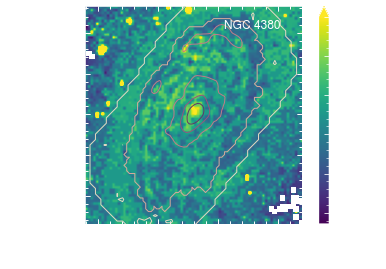

In [4]:
plot_galaxy = "NGC4380"
bin_resolution = "9as"  # don't do 'nyquist'
co_palette = sns.color_palette("ch:s=-.2,r=.6")
co_nyquist_color = [co_palette[0]]
co_9as_color = co_palette[1:5]
# 
with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer.mplstyle"):
    galpath = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{plot_galaxy}/"
    if bin_resolution == "vorbin":
        galaxy_infile = galpath + f"{plot_galaxy}_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star.pkl"
        with open(galaxy_infile, "rb") as f:
            file = dill.load(f)
            ngvs_wcs = file["wcs"]
            ngvs_wcs.array_shape = file["wcs_array_shape"]
    elif bin_resolution == "nyquist" or bin_resolution == "9as":
        galaxy_infile = galpath + f"{plot_galaxy}_regBin_extinctionCorr_{bin_resolution}_ugiz_Sigma-star_noNorm.pkl"
        with open(galaxy_infile, "rb") as f:
            file = dill.load(f)
            ngvs_wcs = file["wcs_binned"]
            ngvs_wcs.array_shape = file["wcs_binned_array_shape"]
    MLi = file["MLi"]
    file = None  # free memory
    # 
    # Load CO data
    #
    co_9as_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{plot_galaxy}/{plot_galaxy}_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
    co_nyquist_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/{plot_galaxy}/{plot_galaxy}_7m+tp_co21_pbcorr_9as_np_round_mom0_Kkms-1.fits"
    co_9as_data, co_9as_header = fits.getdata(co_9as_path, header=True)
    co_nyquist_data, co_nyquist_header = fits.getdata(co_nyquist_path, header=True)
    # 
    # Plot
    # 
    fig, ax = plt.subplots(subplot_kw={"projection": ngvs_wcs})
    img = ax.imshow(MLi, cmap="viridis", vmin=None, vmax=3)
    cbar = fig.colorbar(img, ax=ax, fraction=0.045, extend="max")
    cbar.set_label(r"$M_\star / L_i$ [$\rm M_\odot\; L_{i, \odot}^{-1}$]")
    ax.set_xlabel("RA (J2000)")
    ax.set_ylabel("Dec (J2000)")
    ax.grid(False)
    ax.set_aspect("equal")
    # Add CO contours
    ax.contour(
        co_nyquist_data,
        transform=ax.get_transform(WCS(co_nyquist_header)),
        levels=0,
        colors=co_nyquist_color,
        linewidths=1,
        zorder=3,
    )
    ax.contour(
        co_9as_data,
        transform=ax.get_transform(WCS(co_9as_header)),
        levels=3,
        colors=co_9as_color,
        linewidths=1,
        zorder=3,
    )
    # Add galaxy name (N.B. not checking for `high_i_str` here)
    ax.text(
        0.9,
        0.9,
        re.sub(r"(\d+)", " \\1", plot_galaxy),
        c="w",
        ha="right",
        transform=ax.transAxes,
        zorder=50,  # always plot on top of everything else
        # fontsize=12,
        )
    imgpath = f"/arc/home/IsaacCheng/coop_f2021/galaxies/stellar_mass_densities/{bin_resolution}/"
    # fig.savefig(imgpath + f"{plot_galaxy}_MLi_{bin_resolution}_fromLookupTable_beamer.pdf")
    plt.show()

# (ALREADY DONE) Make 4-panel plots of mass-to-light ratios and stellar mass


In [10]:
import seaborn as sns
sns.color_palette("ch:s=-.2,r=.6")

[(0.8892638312853967, 0.8490264305563623, 0.7570511784894085),
 (0.8312011153070852, 0.6672798070391869, 0.6068051318958765),
 (0.7437124386945118, 0.4851374768470097, 0.5389343244681717),
 (0.5896818664759845, 0.3380467461337321, 0.5001874678981432),
 (0.37244291281972614, 0.22471751711978527, 0.41709125523929924),
 (0.1544379249156812, 0.12779632898103252, 0.2480769565915658)]

In [15]:
%matplotlib inline

# Sorry for weird argument order. Easier for multiprocessing this way

def plot_MLi_and_Sigma_star(
    galaxy,
    inclination,
    bin_resolution,
    vmaxs=None,  # for [MLi, Sigma_star, MLi_err, Sigma_star_err]
    extends=None,  # for colorbar [MLi, Sigma_star, MLi_err, Sigma_star_err]. Must be "neither", "min", "max", or "both"
    snr_target=50,
    cmap="viridis",
    co_contours=True,
    color_palette=sns.color_palette("ch:s=-.2,r=.6"),
    vmins=None,  # for [MLi, Sigma_star, MLi_err, Sigma_star_err]
):

    def _add_galaxy_name(ax, color="w"):
        high_i_str = "*" if inclination >= 80 else ""
        ax.text(
            0.9,
            0.9,
            re.sub(r"(\d+)", " \\1", galaxy) + high_i_str,
            c=color,
            ha="right",
            transform=ax.transAxes,
            zorder=50,  # always plot on top of everything else
            fontsize=12,
        )

    def _add_co_contours(ax, plot_nyquist=True, plot_9as=True):
        if plot_nyquist:
            ax.contour(
                co_nyquist_data,
                transform=ax.get_transform(co_nyquist_wcs),
                levels=0,
                colors=co_nyquist_color,
                linewidths=1,
                zorder=3,
            )
        if plot_9as:
            ax.contour(
                co_9as_data,
                transform=ax.get_transform(co_9as_wcs),
                levels=3,
                colors=co_9as_color,
                linewidths=1,
                zorder=3,
            )
    # 
    # Check inputs
    # 
    if vmins is not None:
        if np.shape(vmins) != (4,):
            raise ValueError("vmins must be a 4-element list for [MLi, Sigma_star, MLi_err, Sigma_star_err]")
    else:
        vmins = [None, None, None, None]
    if vmaxs is not None:
        if np.shape(vmaxs) != (4,):
            raise ValueError("vmaxs must be a 4-element list for [MLi, Sigma_star, MLi_err, Sigma_star_err]")
    else:
        vmaxs = [None, None, None, None]
    if extends is not None:
        if np.shape(extends) != (4,):
            raise ValueError("extends must be a 4-element list for [MLi, Sigma_star, MLi_err, Sigma_star_err]")
    else:
        extends = ["neither", "neither", "neither", "neither"]
    if len(color_palette) < 5:
        raise ValueError("color_palette should have at least 5 elements")
    # 
    # Load MLi and stellar mass density data
    #
    galpath = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{galaxy}/"
    if bin_resolution == "vorbin":
        galaxy_infile = galpath + f"{galaxy}_vorbin_SNR{snr_target}_extinctionCorr_ugiz_Sigma-star_i_corr.pkl"
        with open(galaxy_infile, "rb") as f:
            file = dill.load(f)
            ngvs_wcs = file["wcs"]
            ngvs_wcs.array_shape = file["wcs_array_shape"]
    elif bin_resolution == "nyquist" or bin_resolution == "9as":
        galaxy_infile = galpath + f"{galaxy}_regBin_extinctionCorr_{bin_resolution}_ugiz_Sigma-star_noNorm_i_corr.pkl"
        with open(galaxy_infile, "rb") as f:
            file = dill.load(f)
            ngvs_wcs = file["wcs_binned"]
            ngvs_wcs.array_shape = file["wcs_binned_array_shape"]
    M_density = file ["stellar_mass_density"]
    M_density_err = file["stellar_mass_density_err"]
    MLi = file["MLi"]
    MLi_err = file["MLi_err"]
    file = None  # free memory
    # 
    # Load CO data
    #
    if co_contours:
        if galaxy == "NGC4321":  # no 9 arcsec data since native is 10 arcsec
            co_9as_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3.1/native/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_round_mom0_Kkms-1.fits"
            co_nyquist_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3.1/nyquistPix/15arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_15as_np_round_mom0_Kkms-1.fits"
        else:
            co_9as_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
            co_nyquist_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_np_round_mom0_Kkms-1.fits"
        co_9as_data, co_9as_header = fits.getdata(co_9as_path, header=True)
        co_nyquist_data, co_nyquist_header = fits.getdata(co_nyquist_path, header=True)
        co_9as_wcs = WCS(co_9as_header)
        co_nyquist_wcs = WCS(co_nyquist_header)
        co_nyquist_color = [color_palette[0]]
        co_9as_color = color_palette[1:5]
    # 
    # Plot
    # 
    fig, axs = plt.subplots(2, 2, figsize=(8, 7.25), subplot_kw={"projection": ngvs_wcs})
    ax1, ax2, ax3, ax4 = axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]
    # 
    # Mass to light ratios
    # 
    img1 = ax1.imshow(MLi, cmap=cmap, vmin=vmins[0], vmax=vmaxs[0])
    cbar1 = fig.colorbar(img1, ax=ax1, fraction=0.045, extend=extends[0])
    cbar1.set_label(r"$M_\star / L_i$ [$\rm M_\odot\; L_{i, \odot}^{-1}$]", rotation=270, labelpad=18)
    cbar1.ax.yaxis.set_offset_position("left")
    ax1.set_ylabel("Dec (J2000)")
    ax1.coords[0].set_ticklabel_visible(False)
    ax1.grid(False)
    ax1.set_aspect("equal")
    # 
    # Stellar mass densities
    # 
    img2 = ax2.imshow(M_density, cmap=cmap, norm=mpl.colors.LogNorm(vmin=vmins[1], vmax=vmaxs[1]))
    cbar2 = fig.colorbar(img2, ax=ax2, fraction=0.045, extend=extends[1])
    cbar2.set_label(r"$\Sigma_\star$ [$\rm M_\odot\; pc^{-2}$]", rotation=270, labelpad=18)
    cbar2.ax.yaxis.set_offset_position("left")
    ax2.coords[0].set_ticklabel_visible(False)
    ax2.coords[1].set_ticklabel_visible(False)
    ax2.grid(False)
    ax2.set_aspect("equal")
    # 
    # Mass to light ratio uncertainties
    # 
    img3 = ax3.imshow(MLi_err, cmap=cmap, vmin=vmins[2], vmax=vmaxs[2])
    cbar3 = fig.colorbar(img3, ax=ax3, fraction=0.045, extend=extends[2])
    cbar3.set_label(r"$M_\star / L_i$ Uncertainty [$\rm M_\odot\; L_{i, \odot}^{-1}$]", rotation=270, labelpad=18)
    cbar3.ax.yaxis.set_offset_position("left")
    ax3.set_xlabel("RA (J2000)")
    ax3.set_ylabel("Dec (J2000)")
    ax3.grid(False)
    ax3.set_aspect("equal")
    #
    # Stellar mass density uncertainties
    #
    img4 = ax4.imshow(M_density_err, cmap=cmap, norm=mpl.colors.LogNorm(vmin=vmins[3], vmax=vmaxs[3]))
    cbar4 = fig.colorbar(img4, ax=ax4, fraction=0.045, extend=extends[3])
    cbar4.set_label(r"$\Sigma_\star$ Uncertainty [$\rm M_\odot\; pc^{-2}$]", rotation=270, labelpad=18)
    cbar4.ax.yaxis.set_offset_position("left")
    ax4.set_xlabel("RA (J2000)")
    ax4.coords[1].set_ticklabel_visible(False)
    ax4.grid(False)
    ax4.set_aspect("equal")
    # 
    for tmp_ax in fig.get_axes():
        if tmp_ax.__class__.__name__ == "AxesSubplot":
            continue  # don't modify colorbar axes
        tmp_ax.label_outer()  # share axes per row/column
        tmp_ax.tick_params(color="w")  # white ticks
    for tmp_ax in [ax1, ax2, ax3, ax4]:
        _add_galaxy_name(tmp_ax)  # Add galaxy name
        if co_contours:
            # Bandaid for weird behaviour with 9as contours over Nyquist data
            # if bin_resolution == "nyquist":
            #     tmp_ax.set_xlim(0, MLi.shape[1])
            #     tmp_ax.set_ylim(0, MLi.shape[0])
            try:
                if bin_resolution == "nyquist":
                    # Weird behaviour with 9as contours over Nyquist data.
                    # https://stackoverflow.com/questions/68120545/trying-to-overplot-tess-and-2mass-images-using-wcsaxes-and-astroquery
                    _add_co_contours(tmp_ax, plot_9as=False)
                else:
                    _add_co_contours(tmp_ax, plot_9as=True)
            except ValueError:
                print(f"Unable to add CO contours for {galaxy}")
    plt.subplots_adjust(hspace=0, wspace=0.24)
    imgpath = f"/arc/home/IsaacCheng/coop_f2021/galaxies/stellar_mass_densities/{bin_resolution}/"
    fig.savefig(imgpath + f"{galaxy}_MLi+SigmaStar_{bin_resolution}_fromLookupTable_noNorm_i_corr.pdf")
    plt.close()

In [18]:
with Pool(processes=None) as p:
    p.starmap(
        plot_MLi_and_Sigma_star,
        zip(
            GALAXIES,
            INCLINATIONS,
            repeat("vorbin"),
            repeat([3, None, None, None]),
            repeat(["max", "neither", "neither", "neither"])
        )
    )
print("Done")

: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]
: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]WARNING
WARNING
: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]WARNINGWARNINGWARNING: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]WARNING



WARNING

: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astrop

Done


## 4 panel plot for beamer


In [19]:
%matplotlib inline

# Sorry for weird argument order. Easier for multiprocessing this way
def plot_MLi_and_Sigma_star_beamer(
    galaxy,
    inclination,
    bin_resolution,
    vmaxs=None,  # for [MLi, Sigma_star, MLi_err, Sigma_star_err]
    extends=None,  # for colorbar [MLi, Sigma_star, MLi_err, Sigma_star_err]. Must be "neither", "min", "max", or "both"
    snr_target=50,
    cmap="viridis",
    co_contours=True,
    color_palette=sns.color_palette("ch:s=-.2,r=.6"),
    vmins=None,  # for [MLi, Sigma_star, MLi_err, Sigma_star_err]
):

    def _add_galaxy_name(ax, color="w"):
        high_i_str = "*" if inclination >= 80 else ""
        ax.text(
            0.9,
            0.9,
            re.sub(r"(\d+)", " \\1", galaxy) + high_i_str,
            c=color,
            ha="right",
            transform=ax.transAxes,
            zorder=50,  # always plot on top of everything else
            fontsize=12,
        )

    def _add_co_contours(ax, plot_nyquist=True, plot_9as=True):
        if plot_nyquist:
            ax.contour(
                co_nyquist_data,
                transform=ax.get_transform(co_nyquist_wcs),
                levels=0,
                colors=co_nyquist_color,
                linewidths=1,
                zorder=3,
            )
        if plot_9as:
            ax.contour(
                co_9as_data,
                transform=ax.get_transform(co_9as_wcs),
                levels=3,
                colors=co_9as_color,
                linewidths=1,
                zorder=3,
            )
    # 
    # Check inputs
    # 
    if vmins is not None:
        if np.shape(vmins) != (4,):
            raise ValueError("vmins must be a 4-element list for [MLi, Sigma_star, MLi_err, Sigma_star_err]")
    else:
        vmins = [None, None, None, None]
    if vmaxs is not None:
        if np.shape(vmaxs) != (4,):
            raise ValueError("vmaxs must be a 4-element list for [MLi, Sigma_star, MLi_err, Sigma_star_err]")
    else:
        vmaxs = [None, None, None, None]
    if extends is not None:
        if np.shape(extends) != (4,):
            raise ValueError("extends must be a 4-element list for [MLi, Sigma_star, MLi_err, Sigma_star_err]")
    else:
        extends = ["neither", "neither", "neither", "neither"]
    if len(color_palette) < 5:
        raise ValueError("color_palette should have at least 5 elements")
    # 
    # Load MLi and stellar mass density data
    #
    galpath = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{galaxy}/"
    if bin_resolution == "vorbin":
        galaxy_infile = galpath + f"{galaxy}_vorbin_SNR{snr_target}_extinctionCorr_ugiz_Sigma-star_i_corr.pkl"
        with open(galaxy_infile, "rb") as f:
            file = dill.load(f)
            ngvs_wcs = file["wcs"]
            ngvs_wcs.array_shape = file["wcs_array_shape"]
    elif bin_resolution == "nyquist" or bin_resolution == "9as":
        galaxy_infile = galpath + f"{galaxy}_regBin_extinctionCorr_{bin_resolution}_ugiz_Sigma-star_noNorm_i_corr.pkl"
        with open(galaxy_infile, "rb") as f:
            file = dill.load(f)
            ngvs_wcs = file["wcs_binned"]
            ngvs_wcs.array_shape = file["wcs_binned_array_shape"]
    M_density = file ["stellar_mass_density"]
    M_density_err = file["stellar_mass_density_err"]
    MLi = file["MLi"]
    MLi_err = file["MLi_err"]
    file = None  # free memory
    # 
    # Load CO data
    #
    if co_contours:
        if galaxy == "NGC4321":  # no 9 arcsec data since native is 10 arcsec
            co_9as_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3.1/native/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_round_mom0_Kkms-1.fits"
            co_nyquist_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3.1/nyquistPix/15arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_15as_np_round_mom0_Kkms-1.fits"
        else:
            co_9as_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
            co_nyquist_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_np_round_mom0_Kkms-1.fits"
        co_9as_data, co_9as_header = fits.getdata(co_9as_path, header=True)
        co_nyquist_data, co_nyquist_header = fits.getdata(co_nyquist_path, header=True)
        co_9as_wcs = WCS(co_9as_header)
        co_nyquist_wcs = WCS(co_nyquist_header)
        co_nyquist_color = [color_palette[0]]
        co_9as_color = color_palette[1:5]
    # 
    # Plot
    # 
    with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer.mplstyle"):
        fig, axs = plt.subplots(2, 2, figsize=(10, 7.25), subplot_kw={"projection": ngvs_wcs})
        ax1, ax2, ax3, ax4 = axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]
        # 
        # Mass to light ratios
        # 
        img1 = ax1.imshow(MLi, cmap=cmap, vmin=vmins[0], vmax=vmaxs[0])
        cbar1 = fig.colorbar(img1, ax=ax1, fraction=0.045, extend=extends[0])
        cbar1.set_label(r"$M_\star / L_i$ [$\rm M_\odot\; L_{i, \odot}^{-1}$]", rotation=270, labelpad=18)
        cbar1.ax.yaxis.set_offset_position("left")
        ax1.set_ylabel("Dec (J2000)")
        ax1.coords[0].set_ticklabel_visible(False)
        ax1.grid(False)
        ax1.set_aspect("equal")
        # 
        # Stellar mass densities
        # 
        img2 = ax2.imshow(M_density, cmap=cmap, norm=mpl.colors.LogNorm(vmin=vmins[1], vmax=vmaxs[1]))
        cbar2 = fig.colorbar(img2, ax=ax2, fraction=0.045, extend=extends[1])
        cbar2.set_label(r"$\Sigma_\star$ [$\rm M_\odot\; pc^{-2}$]", rotation=270, labelpad=18)
        cbar2.ax.yaxis.set_offset_position("left")
        ax2.coords[0].set_ticklabel_visible(False)
        ax2.coords[1].set_ticklabel_visible(False)
        ax2.grid(False)
        ax2.set_aspect("equal")
        # 
        # Mass to light ratio uncertainties
        # 
        img3 = ax3.imshow(MLi_err, cmap=cmap, vmin=vmins[2], vmax=vmaxs[2])
        cbar3 = fig.colorbar(img3, ax=ax3, fraction=0.045, extend=extends[2])
        cbar3.set_label(r"$M_\star / L_i$ Uncertainty [$\rm M_\odot\; L_{i, \odot}^{-1}$]", rotation=270, labelpad=18)
        cbar3.ax.yaxis.set_offset_position("left")
        ax3.set_xlabel("RA (J2000)")
        ax3.set_ylabel("Dec (J2000)")
        ax3.grid(False)
        ax3.set_aspect("equal")
        #
        # Stellar mass density uncertainties
        #
        img4 = ax4.imshow(M_density_err, cmap=cmap, norm=mpl.colors.LogNorm(vmin=vmins[3], vmax=vmaxs[3]))
        cbar4 = fig.colorbar(img4, ax=ax4, fraction=0.045, extend=extends[3])
        cbar4.set_label(r"$\Sigma_\star$ Uncertainty [$\rm M_\odot\; pc^{-2}$]", rotation=270, labelpad=18)
        cbar4.ax.yaxis.set_offset_position("left")
        ax4.set_xlabel("RA (J2000)")
        ax4.coords[1].set_ticklabel_visible(False)
        ax4.grid(False)
        ax4.set_aspect("equal")
        # 
        for tmp_ax in fig.get_axes():
            if tmp_ax.__class__.__name__ == "AxesSubplot":
                continue  # don't modify colorbar axes
            tmp_ax.label_outer()  # share axes per row/column
            tmp_ax.tick_params(color="w")  # white ticks
        for tmp_ax in [ax1, ax2, ax3, ax4]:
            _add_galaxy_name(tmp_ax)  # Add galaxy name
            if co_contours:
                # Bandaid for weird behaviour with 9as contours over Nyquist data
                # if bin_resolution == "nyquist":
                #     tmp_ax.set_xlim(0, MLi.shape[1])
                #     tmp_ax.set_ylim(0, MLi.shape[0])
                try:
                    if bin_resolution == "nyquist":
                        # Weird behaviour with 9as contours over Nyquist data.
                        # https://stackoverflow.com/questions/68120545/trying-to-overplot-tess-and-2mass-images-using-wcsaxes-and-astroquery
                        _add_co_contours(tmp_ax, plot_9as=False)
                    else:
                        _add_co_contours(tmp_ax, plot_9as=True)
                except ValueError:
                    print(f"Unable to add CO contours for {galaxy}")
        plt.subplots_adjust(hspace=0.05, wspace=0.3)
        imgpath = f"/arc/home/IsaacCheng/coop_f2021/galaxies/stellar_mass_densities/{bin_resolution}/"
        fig.savefig(imgpath + f"{galaxy}_MLi+SigmaStar_{bin_resolution}_fromLookupTable_noNorm_i_corr_beamer.pdf")
        plt.close()

In [22]:
with Pool(processes=None) as p:
    p.starmap(
        plot_MLi_and_Sigma_star_beamer,
        zip(
            GALAXIES,
            INCLINATIONS,
            repeat("vorbin"),
            repeat([3, None, None, None]),
            repeat(["max", "neither", "neither", "neither"])
        )
    )
print("Done")
# for gal, i in zip(GALAXIES, INCLINATIONS):
#     if gal != "NGC4380":
#         continue
#     plot_MLi_and_Sigma_star_beamer(
#         gal,
#         i,
#         "vorbin",
#         vmaxs=[3, None, None, None],
#         extends=["max", "neither", "neither", "neither"],
#     )
# print("Done")



: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]WARNING



: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]
: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]WARNING: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]
: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]

: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]WARNING: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]WARNING
WARNINGWARNINGWARNINGWARNING
: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (

Done


In [ ]:
galpath = "/arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380/"
galaxy_infile = galpath + "NGC4380_regBin_extinctionCorr_nyquist_ugiz_Sigma-star_noNorm_i_corr.pkl"
with open(galaxy_infile, "rb") as f:
    file = dill.load(f)
    ngvs_wcs = file["wcs_binned"]
    ngvs_wcs.array_shape = file["wcs_binned_array_shape"]
M_density = file ["stellar_mass_density"]
M_density_err = file["stellar_mass_density_err"]
MLi = file["MLi"]
MLi_err = file["MLi_err"]
print(M_density.shape)
print(ngvs_wcs)
fig, ax = plt.subplots(subplot_kw={"projection": ngvs_wcs})
# img = ax.imshow(MLi, vmax=3)
img = ax.imshow(M_density, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(img)
plt.show()

# (ALREADY DONE) Determine mean stellar mass density in vorbin image


## Naive approach

Simply take the mean/median over whole image excluding flagged areas


In [4]:

mean_M_densities = []
median_M_densities = []
for galaxy in GALAXIES:
    galpath = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{galaxy}/"
    galaxy_infile = galpath + f"{galaxy}_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star.pkl"
    with open(galaxy_infile, "rb") as f:
        file = dill.load(f)
        M_density = file ["stellar_mass_density"]
        file = None  # free memory
    mean_M_densities.append(np.nanmean(M_density))
    median_M_densities.append(np.nanmedian(M_density))

decr_mean_M_densities_idx = np.argsort(mean_M_densities)[::-1]
decr_median_M_densities_idx = np.argsort(median_M_densities)[::-1]

print(*decr_mean_M_densities_idx, sep=", ")
print(*decr_median_M_densities_idx, sep=", ")

18, 21, 27, 20, 28, 29, 30, 26, 0, 2, 25, 32, 17, 9, 1, 35, 14, 19, 8, 24, 12, 16, 6, 34, 4, 31, 33, 22, 13, 10, 5, 3, 23, 7, 11, 15
21, 27, 30, 26, 20, 0, 29, 9, 17, 25, 28, 24, 34, 18, 12, 35, 19, 32, 6, 10, 33, 4, 5, 1, 2, 11, 14, 16, 13, 22, 7, 8, 3, 15, 23, 31


In [27]:

mean_M_densities = []
median_M_densities = []
for galaxy in GALAXIES:
    galpath = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{galaxy}/"
    galaxy_infile = galpath + f"{galaxy}_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pkl"
    with open(galaxy_infile, "rb") as f:
        file = dill.load(f)
        M_density = file ["stellar_mass_density"]
        file = None  # free memory
    mean_M_densities.append(np.nanmean(M_density))
    median_M_densities.append(np.nanmedian(M_density))

decr_mean_M_densities_idx = np.argsort(mean_M_densities)[::-1]
decr_median_M_densities_idx = np.argsort(median_M_densities)[::-1]

print(*decr_mean_M_densities_idx, sep=", ")
print(*decr_median_M_densities_idx, sep=", ")

21, 29, 20, 30, 26, 27, 25, 18, 9, 32, 17, 28, 0, 34, 24, 35, 4, 6, 19, 12, 7, 2, 33, 13, 1, 11, 14, 8, 23, 16, 5, 31, 22, 10, 3, 15
30, 26, 21, 29, 20, 9, 25, 27, 17, 34, 24, 0, 32, 28, 12, 19, 35, 4, 6, 18, 11, 33, 7, 13, 5, 10, 1, 2, 14, 16, 22, 23, 8, 3, 15, 31


## Better approach

Consider only vorbins with SNR >= 30 and treat each bin as 1 pixel (because it technically
is). Now take mean/median of these unique bins.

This prevents edge on galaxies from being unfairly lowered in average stellar mass
densities because they have so much background relative to face-on galaxies. But the
background has low SNR and thus we don't weight the surroundings too heavily regardless of
optical inclination.


In [3]:

mean_M_densities = []
median_M_densities = []
for galaxy in GALAXIES:
    galpath = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{galaxy}/"
    galaxy_infile = galpath + f"{galaxy}_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star.pkl"
    with open(galaxy_infile, "rb") as f:
        file = dill.load(f)
        M_density = file["stellar_mass_density"].flatten()
        isgood_snr = file["isgood_snr"].flatten()
        binNum_arr = file["binNum_arr"].flatten()
        file = None  # free memory
    _, good_bin_idx = np.unique(binNum_arr[isgood_snr], return_index=True)
    mean_M_densities.append(np.nanmean(M_density[good_bin_idx]))
    median_M_densities.append(np.nanmedian(M_density[good_bin_idx]))

decr_mean_M_densities_idx = np.argsort(mean_M_densities)[::-1]
decr_median_M_densities_idx = np.argsort(median_M_densities)[::-1]

print(*decr_mean_M_densities_idx, sep=", ")
print(*decr_median_M_densities_idx, sep=", ")
# print(mean_M_densities[decr_mean_M_densities_idx])
# print(median_M_densities[decr_median_M_densities_idx])

18, 21, 27, 29, 16, 28, 14, 0, 30, 35, 26, 12, 17, 32, 25, 9, 34, 33, 19, 24, 20, 2, 4, 11, 22, 3, 6, 1, 8, 5, 23, 7, 10, 31, 15, 13
21, 0, 18, 30, 27, 29, 26, 14, 35, 12, 16, 28, 17, 34, 9, 19, 32, 25, 11, 24, 20, 33, 5, 4, 7, 6, 22, 10, 3, 2, 8, 15, 13, 1, 23, 31


In [28]:

mean_M_densities = []
median_M_densities = []
for galaxy in GALAXIES:
    galpath = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{galaxy}/"
    galaxy_infile = galpath + f"{galaxy}_vorbin_SNR50_extinctionCorr_ugiz_Sigma-star_i_corr.pkl"
    with open(galaxy_infile, "rb") as f:
        file = dill.load(f)
        M_density = file["stellar_mass_density"].flatten()
        isgood_snr = file["isgood_snr"].flatten()
        binNum_arr = file["binNum_arr"].flatten()
        file = None  # free memory
    _, good_bin_idx = np.unique(binNum_arr[isgood_snr], return_index=True)
    mean_M_densities.append(np.nanmean(M_density[good_bin_idx]))
    median_M_densities.append(np.nanmedian(M_density[good_bin_idx]))

decr_mean_M_densities_idx = np.argsort(mean_M_densities)[::-1]
decr_median_M_densities_idx = np.argsort(median_M_densities)[::-1]

print(*decr_mean_M_densities_idx, sep=", ")
print(*decr_median_M_densities_idx, sep=", ")
# print(mean_M_densities[decr_mean_M_densities_idx])
# print(median_M_densities[decr_median_M_densities_idx])

29, 18, 21, 30, 27, 26, 28, 0, 17, 35, 25, 9, 12, 34, 32, 16, 14, 24, 4, 20, 11, 33, 19, 6, 7, 23, 2, 5, 22, 3, 1, 8, 13, 10, 31, 15
30, 29, 21, 26, 0, 17, 18, 27, 35, 9, 34, 12, 25, 28, 32, 11, 24, 19, 20, 14, 4, 16, 33, 7, 6, 5, 13, 22, 10, 3, 23, 2, 8, 15, 1, 31


# Radial Profiles

Base number of annuli on CO annuli


In [3]:
co_rad_profs_path = "/arc/home/IsaacCheng/coop_f2021/galaxies/gas_fraction/gas_fraction_i_corr_NGVS-VERTICO_noNorm.pkl"
with open(co_rad_profs_path, "rb") as f:
    file = dill.load(f)
    galaxies = file["galaxies"]
    inclinations = file["inclinations"]
    position_angles = file["position_angles"]
    centers = file["centers"]
    radial_profiles = file["radial_profiles"]
    annulus_widths_arcsec = file["annulus_widths_arcsec"]
    file = None  # free memory

avg_function = radial_profiles[0].rp_options["func"]
radio_n_annulis = []
for rp in radial_profiles:
    radio_n_annulis.append(len(rp.annuli))
print(radio_n_annulis)
print(galaxies)
# print(centers)

[3, 19, 21, 9, 16, 3, 7, 6, 18, 15, 9, 5, 5, 5, 10, 8, 13, 3, 4, 4, 7, 7, 7, 4, 12, 11, 6, 5, 8, 11, 4, 7, 6, 8, 8, 5]
['IC3392' 'NGC4192' 'NGC4216' 'NGC4222' 'NGC4254' 'NGC4294' 'NGC4298'
 'NGC4299' 'NGC4302' 'NGC4321' 'NGC4330' 'NGC4351' 'NGC4380' 'NGC4383'
 'NGC4388' 'NGC4396' 'NGC4402' 'NGC4405' 'NGC4419' 'NGC4424' 'NGC4450'
 'NGC4501' 'NGC4522' 'NGC4532' 'NGC4535' 'NGC4548' 'NGC4567' 'NGC4568'
 'NGC4569' 'NGC4579' 'NGC4580' 'NGC4607' 'NGC4651' 'NGC4654' 'NGC4689'
 'NGC4694']


In [4]:
# ! MAKE SURE YOU RUN CELL 2 (the one with HIGH_I_HEIGHTS)

I_THRESHOLD = 80

def get_vorbin_rp(
    galaxy, i, pa,
    center,  # SkyCoord
    radio_annulus_width,  # must be a float in units of arcsec
    num_radio_annuli,
    rp_quantity="M_density",  # "M_density", "MLi", or "u-g"
    snr_mask=False,
    n_annuli=None,  # overrides n_annuli calculation
    min_width=None,  # if given, must be a float in units of arcsec
    avg_function="mean",
    include_bad=False,
    snr_target=50, bootstrap_errs=True, bootstrap_seed=1234,
):
    """
    Be careful. I'm not doing any input checks
    """
    # 
    # Load stellar mass density data
    # 
    galpath = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{galaxy}/"
    galaxy_infile = galpath + f"{galaxy}_vorbin_SNR{snr_target}_extinctionCorr_ugiz_Sigma-star_i_corr.pkl"
    with open(galaxy_infile, "rb") as f:
        file = dill.load(f)
        if rp_quantity == "M_density":
            rp_quantity = file ["stellar_mass_density"]
            rp_quantity_err = file["stellar_mass_density_err"]
        elif rp_quantity == "MLi":
            rp_quantity = file ["MLi"]
            rp_quantity_err = file["MLi_err"]
        elif rp_quantity == "u-g":
            uband_rel_mag = file ["uband_rel_mag"]
            uband_rel_mag_err = file["uband_rel_mag_err"]
            gband_rel_mag = file ["gband_rel_mag"]
            gband_rel_mag_err = file["gband_rel_mag_err"]
            rp_quantity = uband_rel_mag - gband_rel_mag
            rp_quantity_err = np.sqrt(uband_rel_mag_err ** 2 + gband_rel_mag_err ** 2)
            # Free memory
            uband_rel_mag = uband_rel_mag_err = None
            gband_rel_mag = gband_rel_mag_err = None
        else:
            raise ValueError(f"rp_quantity must be one of 'M_density', 'MLi', or 'u-g'")
        gal_wcs = file["wcs"]
        gal_wcs.array_shape = file["wcs_array_shape"]
        if snr_mask:
            isgood_snr = file["isgood_snr"]
            rp_quantity[~isgood_snr] = np.nan
            rp_quantity_err[~isgood_snr] = np.nan
            isgood_snr = None  # free memory
        file = None  # free memory
    #
    # Get radial profile parameters
    #
    if i >= I_THRESHOLD:
        high_i_height = HIGH_I_HEIGHTS_ARCSEC[galaxy == HIGH_I_GALAXIES]
        if high_i_height.size != 1:
            raise ValueError("Failed on {galaxy} with high_i_height={high_i_height}")
        high_i_height = high_i_height[0] * u.arcsec
    else:
        high_i_height = None
    print(f"{galaxy} high_i_height:", high_i_height)
    # 
    # Get worst image quality to use as min_width in radial profile
    # 
    if min_width is None:
        # Load data
        uband_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{galaxy}/{galaxy}_u_data.fits"
        gband_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{galaxy}/{galaxy}_g_data.fits"
        iband_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{galaxy}/{galaxy}_i_data.fits"
        zband_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{galaxy}/{galaxy}_z_data.fits"
        # 
        uband_header = fits.getheader(uband_path)
        gband_header = fits.getheader(gband_path)
        iband_header = fits.getheader(iband_path)
        zband_header = fits.getheader(zband_path)
        # 
        header_order = ["u", "g", "i", "z"]
        header_lst = [uband_header, gband_header, iband_header, zband_header]
        min_width, min_width_idx = fu.get_worst_img_qual(
            header_lst, header_key="IQMAX", header_unit=u.arcsec
        )
        print(f"{galaxy}'s worst image quality is", min_width, f"from {header_order[min_width_idx]}-band data")
        min_width = min_width.to(u.arcsec).value
    if n_annuli is None:
        n_annuli = int(np.ceil((radio_annulus_width / min_width) * num_radio_annuli))
        print(f"INFO: Using {n_annuli} n_annuli")
    else:
        print(f"INFO: Using given n_annuli ({n_annuli}) instead of automatically-calculated n_annuli")
    #
    # Make radial profile
    #
    galaxy_rp = RadialProfile(rp_quantity, center, i, pa, noise=rp_quantity_err)
    galaxy_rp = galaxy_rp.calc_radial_profile(
        i_threshold=I_THRESHOLD,
        n_annuli=n_annuli,
        min_width=min_width * u.arcsec,
        wcs=gal_wcs,
        # header=gal_header,
        include_bad=include_bad,
        method="exact",
        func=avg_function,
        is_radio=False,
        high_i_height=high_i_height,
        bootstrap_errs=bootstrap_errs,
        bootstrap_seed=bootstrap_seed,
    )
    return galaxy_rp, n_annuli, min_width  # min_width is scalar in arcsec

In [5]:
# ! MAKE SURE YOU RUN CELL 2 (the one with HIGH_I_HEIGHTS)

I_THRESHOLD = 80

def get_vorbin_uncertainty_rp(
    galaxy, i, pa,
    center,  # SkyCoord
    radio_annulus_width,  # must be a float in units of arcsec
    num_radio_annuli,
    rp_quantity="M_density",  # "M_density", "MLi", or "u-g"
    snr_mask=False,
    n_annuli=None,  # overrides n_annuli calculation
    min_width=None,  # if given, must be a float in units of arcsec
    avg_function="mean",
    include_bad=False,
    snr_target=50, bootstrap_errs=True, bootstrap_seed=1234,
):
    """
    Be careful. I'm not doing any input checks.
    
    Radial profile for average uncertainty
    """
    # 
    # Load stellar mass density data
    # 
    galpath = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{galaxy}/"
    galaxy_infile = galpath + f"{galaxy}_vorbin_SNR{snr_target}_extinctionCorr_ugiz_Sigma-star_i_corr.pkl"
    with open(galaxy_infile, "rb") as f:
        file = dill.load(f)
        if rp_quantity == "M_density":
            rp_quantity = file ["stellar_mass_density"]
            rp_quantity_err = file["stellar_mass_density_err"]
        elif rp_quantity == "MLi":
            rp_quantity = file ["MLi"]
            rp_quantity_err = file["MLi_err"]
        elif rp_quantity == "u-g":
            uband_rel_mag = file ["uband_rel_mag"]
            uband_rel_mag_err = file["uband_rel_mag_err"]
            gband_rel_mag = file ["gband_rel_mag"]
            gband_rel_mag_err = file["gband_rel_mag_err"]
            rp_quantity = uband_rel_mag - gband_rel_mag
            rp_quantity_err = np.sqrt(uband_rel_mag_err ** 2 + gband_rel_mag_err ** 2)
            # Free memory
            uband_rel_mag = uband_rel_mag_err = None
            gband_rel_mag = gband_rel_mag_err = None
        else:
            raise ValueError(f"rp_quantity must be one of 'M_density', 'MLi', or 'u-g'")
        gal_wcs = file["wcs"]
        gal_wcs.array_shape = file["wcs_array_shape"]
        if snr_mask:
            isgood_snr = file["isgood_snr"]
            rp_quantity[~isgood_snr] = np.nan
            rp_quantity_err[~isgood_snr] = np.nan
            isgood_snr = None  # free memory
        file = None  # free memory
    #
    # Get radial profile parameters
    #
    if i >= I_THRESHOLD:
        high_i_height = HIGH_I_HEIGHTS_ARCSEC[galaxy == HIGH_I_GALAXIES]
        if high_i_height.size != 1:
            raise ValueError("Failed on {galaxy} with high_i_height={high_i_height}")
        high_i_height = high_i_height[0] * u.arcsec
    else:
        high_i_height = None
    print(f"{galaxy} high_i_height:", high_i_height)
    # 
    # Get worst image quality to use as min_width in radial profile
    # 
    if min_width is None:
        # Load data
        uband_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{galaxy}/{galaxy}_u_data.fits"
        gband_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{galaxy}/{galaxy}_g_data.fits"
        iband_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{galaxy}/{galaxy}_i_data.fits"
        zband_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{galaxy}/{galaxy}_z_data.fits"
        # 
        uband_header = fits.getheader(uband_path)
        gband_header = fits.getheader(gband_path)
        iband_header = fits.getheader(iband_path)
        zband_header = fits.getheader(zband_path)
        # 
        header_order = ["u", "g", "i", "z"]
        header_lst = [uband_header, gband_header, iband_header, zband_header]
        min_width, min_width_idx = fu.get_worst_img_qual(
            header_lst, header_key="IQMAX", header_unit=u.arcsec
        )
        print(f"{galaxy}'s worst image quality is", min_width, f"from {header_order[min_width_idx]}-band data")
        min_width = min_width.to(u.arcsec).value
    if n_annuli is None:
        n_annuli = int(np.ceil((radio_annulus_width / min_width) * num_radio_annuli))
        print(f"INFO: Using {n_annuli} n_annuli")
    else:
        print(f"INFO: Using given n_annuli ({n_annuli}) instead of automatically-calculated n_annuli")
    #
    # Make radial profile
    #
    galaxy_rp = RadialProfile(rp_quantity_err, center, i, pa)
    galaxy_rp = galaxy_rp.calc_radial_profile(
        i_threshold=I_THRESHOLD,
        n_annuli=n_annuli,
        min_width=min_width * u.arcsec,
        wcs=gal_wcs,
        # header=gal_header,
        include_bad=include_bad,
        method="exact",
        func=avg_function,
        is_radio=False,
        high_i_height=high_i_height,
        bootstrap_errs=bootstrap_errs,
        bootstrap_seed=bootstrap_seed,
    )
    return galaxy_rp, n_annuli, min_width  # min_width is scalar in arcsec

## Making radial profiles for all NGVS-VERTICO galaxies

Stellar Mass Density, Mass-to-Light Ratio, and u-g Colour


### Save radial profile data to pickle files

The pickle files are huge since I am saving a copy of the array for each data & noise area masks!!!
Will add option to reduce memory usage in the future


In [ ]:
# # 
# # MULTIPROCESSING USES TOO MUCH MEMORY
# # 
# quantity = "M_density"
# use_snr_mask = False
# use_snr_mask_str = "yesSNRmask" if use_snr_mask else "noSNRmask"
# with Pool(processes=None) as p:
#     radial_profiles, n_annulis, min_width_arcsecs = zip(
#         *p.starmap(
#             get_vorbin_rp,
#             zip(
#                 galaxies,
#                 inclinations,
#                 position_angles,
#                 centers,
#                 annulus_widths_arcsec,
#                 radio_n_annulis,
#                 repeat(quantity),
#                 repeat(use_snr_mask),
#             )
#         )
#     )
# 
# print("Done")

None
IC3392's worst image quality is 1.09 arcsec from g-band data
Min width (pixels): 5.866512059561565
None
NGC4405's worst image quality is 1.01 arcsec from u-band data
Min width (pixels): 5.436320964667331
None
NGC4580's worst image quality is None
1.12 arcsecNGC4299's worst image quality is  None1.0 arcsecfrom u-band data

 from u-band data
NGC4351's worst image quality isMin width (pixels):  Min width (pixels):1.01 arcsec6.028192826728225 
from u-band data None5.38472873050421940.0 arcsec



25.0 arcsecMin width (pixels):
NGC4294's worst image quality is 5.438020322892277 1.0 arcsecNGC4222's worst image quality is
 NGC4522's worst image quality is   0.99 arcsec 1.1 arcsecfrom u-band data
from u-band data
from u-band dataMin width (pixels): 
Min width (pixels):5.328355154837483 
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
5.920815307808093
Info: Inclination greater than i_threshold. Fitting rectangles along major axis i

 from u-band data


Min width (pixels): 5.651500093041777
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Height (pixels): 296.0309572545693
None
NGC4651's worst image quality is 60.0 arcsec
0.96 arcsec from z-band data
Min width (pixels): 5.167810729751637
NGC4216's worst image quality is 

0.99 arcsec from u-band data
Min width (pixels): 5.328355154837483
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Height (pixels): 322.9306154446959
None
NGC4654's worst image quality is 1.08 arcsec from u-band data
Min width (pixels): 5.814874277094613

None
NGC4689's worst image quality is 1.05 arcsec from u-band data
Min width (pixels): 5.654098744635938


None
NGC4694's worst image quality is 1.2 arcsec from u-band data
Min width (pixels): 6.4620540896918


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:607: RuntimeWarning: invalid value encountered in double_scalars
  avg_signal = avg_signal / np.nansum(signal_area_mask)
/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:613: RuntimeWarning: invalid value encountered in double_scalars
  avg_noise = np.sqrt(avg_noise) / np.nansum(noise_area_mask)
/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:555: RuntimeWarning: invalid value encountered in true_divide
  bootstraps = bootstraps / np.nansum(_area)
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [8]:
quantity = "u-g"  # "M_density", "MLi", or "u-g"
use_snr_mask = False
use_snr_mask_str = "yesSNRmask" if use_snr_mask else "noSNRmask"

for gal, i, pa, cen, radio_width, radio_n_annuli in zip(galaxies, inclinations, position_angles, centers, annulus_widths_arcsec, radio_n_annulis):
    # Only re-run high-i galaxies (to fix their radii values)
    if i < I_THRESHOLD:
        continue
    #
    # Do radial profile
    #
    gal_rp, gal_n_annuli, gal_min_width_arcsec = get_vorbin_rp(
        gal, i, pa, cen, radio_width, radio_n_annuli, rp_quantity=quantity, snr_mask=use_snr_mask
    )
    #
    # Pickle results
    #
    gal_dir_str = f"/arc/home/IsaacCheng/coop_f2021/galaxies/vorbin_radial_profiles/{gal}/"
    gal_rp_outfile = gal_dir_str + f"{gal}_{quantity}_rps_NGVS-VERTICO_{use_snr_mask_str}_i_corr.pkl"
    with open(gal_rp_outfile, "wb") as f:
        dill.dump(
            {
                "radial_profile_quantity": quantity,
                "used_snr_mask": use_snr_mask,
                "galaxy": gal,
                "inclinations": i,
                "position_angle": pa,
                "center": cen,
                "radial_profile": gal_rp,
                "n_annuli": gal_n_annuli,
                "min_width_arcsec": gal_min_width_arcsec,
            },
            f
        )
    print("Pickled", gal_rp_outfile)
print("DONE!")

NGC4192 high_i_height: 80.0 arcsec
NGC4192's worst image quality is 1.0 arcsec from z-band data
INFO: Using 171 n_annuli
Min width (pixels): 5.382963122643468
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Height (pixels): 430.6370498114774
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/vorbin_radial_profiles/NGC4192/NGC4192_u-g_rps_NGVS-VERTICO_noSNRmask_i_corr.pkl


NGC4216 high_i_height: 60.0 arcsec
NGC4216's worst image quality is 0.99 arcsec from u-band data
INFO: Using 191 n_annuli
Min width (pixels): 5.328355154837483
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Height (pixels): 322.9306154446959
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/vorbin_radial_profiles/NGC4216/NGC4216_u-g_rps_NGVS-VERTICO_noSNRmask_i_corr.pkl


NGC4222 high_i_height: 25.0 arcsec
NGC4222's worst image quality is 0.99 arcsec from u-band data
INFO: Using 82 n_annuli
Min width (pixels): 5.328355154837483
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Height (pixels): 134.55442310195662
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/vorbin_radial_profiles/NGC4222/NGC4222_u-g_rps_NGVS-VERTICO_noSNRmask_i_corr.pkl


NGC4302 high_i_height: 55.0 arcsec
NGC4302's worst image quality is 1.05 arcsec from u-band data
INFO: Using 155 n_annuli
Min width (pixels): 5.651500093041777
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Height (pixels): 296.0309572545693


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:607: RuntimeWarning: invalid value encountered in double_scalars
  avg_signal = avg_signal / np.nansum(signal_area_mask)
/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:613: RuntimeWarning: invalid value encountered in double_scalars
  avg_noise = np.sqrt(avg_noise) / np.nansum(noise_area_mask)
/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:555: RuntimeWarning: invalid value encountered in true_divide
  bootstraps = bootstraps / np.nansum(_area)
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/vorbin_radial_profiles/NGC4302/NGC4302_u-g_rps_NGVS-VERTICO_noSNRmask_i_corr.pkl


NGC4330 high_i_height: 38.0 arcsec
NGC4330's worst image quality is 1.04 arcsec from u-band data
INFO: Using 78 n_annuli
Min width (pixels): 5.599863949220481
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Height (pixels): 204.6104135292099
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/vorbin_radial_profiles/NGC4330/NGC4330_u-g_rps_NGVS-VERTICO_noSNRmask_i_corr.pkl


NGC4388 high_i_height: 65.0 arcsec
NGC4388's worst image quality is 1.01 arcsec from u-band data
INFO: Using 90 n_annuli
Min width (pixels): 5.434760546562449
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Height (pixels): 349.76181735302896


/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:607: RuntimeWarning: invalid value encountered in double_scalars
  avg_signal = avg_signal / np.nansum(signal_area_mask)
/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:613: RuntimeWarning: invalid value encountered in double_scalars
  avg_noise = np.sqrt(avg_noise) / np.nansum(noise_area_mask)
/arc/home/IsaacCheng/coop_f2021/packages/radial_profile_utils.py:555: RuntimeWarning: invalid value encountered in true_divide
  bootstraps = bootstraps / np.nansum(_area)
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/vorbin_radial_profiles/NGC4388/NGC4388_u-g_rps_NGVS-VERTICO_noSNRmask_i_corr.pkl


NGC4396 high_i_height: 43.0 arcsec
NGC4396's worst image quality is 1.01 arcsec from u-band data
INFO: Using 72 n_annuli
Min width (pixels): 5.436320964667331
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Height (pixels): 231.44732819870816
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/vorbin_radial_profiles/NGC4396/NGC4396_u-g_rps_NGVS-VERTICO_noSNRmask_i_corr.pkl


NGC4402 high_i_height: 45.0 arcsec
NGC4402's worst image quality is 1.01 arcsec from u-band data
INFO: Using 116 n_annuli
Min width (pixels): 5.434760546562449
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Height (pixels): 242.14279662902004
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/vorbin_radial_profiles/NGC4402/NGC4402_u-g_rps_NGVS-VERTICO_noSNRmask_i_corr.pkl


NGC4522 high_i_height: 40.0 arcsec
NGC4522's worst image quality is 1.1 arcsec from u-band data
INFO: Using 58 n_annuli
Min width (pixels): 5.920815307808093
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Height (pixels): 215.30237482938517
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/vorbin_radial_profiles/NGC4522/NGC4522_u-g_rps_NGVS-VERTICO_noSNRmask_i_corr.pkl


NGC4607 high_i_height: 70.0 arcsec
NGC4607's worst image quality is 1.12 arcsec from u-band data
INFO: Using 57 n_annuli
Min width (pixels): 6.031211351074133
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Height (pixels): 376.9507094421333
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/vorbin_radial_profiles/NGC4607/NGC4607_u-g_rps_NGVS-VERTICO_noSNRmask_i_corr.pkl
DONE!


### Plot radial profiles of data from pickle files

See the section below for plotting their uncertainties


In [9]:
# Set these values
QUANTITY_TO_PLOT = "u-g" # "M_density", "MLi", or "u-g"
USE_SNR_MASK = False
cmap = "plasma"  # "magma" for M_density and MLi, "plasma" for u-g
# 
if QUANTITY_TO_PLOT == "M_density":
    quantity_str = r"$\rm \Sigma_\star$ [$\rm M_\odot\; pc^{-2}$]"
elif QUANTITY_TO_PLOT == "MLi":
    quantity_str = r"$M_\star / L_i$ [$\rm M_\odot\; L_{i, \odot}$]"
elif QUANTITY_TO_PLOT == "u-g":
    quantity_str = "u-g Colour"
else:
    raise ValueError("QUANTITY_TO_PLOT must be 'M_density', 'MLi', or 'u-g'")
use_snr_mask_str = "yesSNRmask" if USE_SNR_MASK else "noSNRmask"
# 
for gal in galaxies:
    # Only re-run high-i galaxies (to fix their radii values)
    if gal not in HIGH_I_GALAXIES:
        continue
    print("Plotting", gal)
    #
    # Load radial profile data
    #
    gal_dir_str = f"/arc/home/IsaacCheng/coop_f2021/galaxies/vorbin_radial_profiles/{gal}/"
    gal_rp_infile = gal_dir_str + f"{gal}_{QUANTITY_TO_PLOT}_rps_NGVS-VERTICO_{use_snr_mask_str}_i_corr.pkl"
    with open(gal_rp_infile, "rb") as f:
        file = dill.load(f)
        gal_rp = file["radial_profile"]
        file = None  # free memory
    vorbin_wcs = gal_rp.rp_options["wcs"]
    px_to_kpc = fu.calc_pc_per_px(vorbin_wcs, GALDIST)[0][0] / 1000  # assume square pixels
    # 
    # Plot
    #
    fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
    ax1 = fig.add_subplot(2, 1, 1, projection=vorbin_wcs)
    #
    # Plot data
    #
    if QUANTITY_TO_PLOT == "M_density":
        img1 = ax1.imshow(gal_rp.data, cmap=cmap, norm=mpl.colors.LogNorm())
        extend = "neither"
    elif QUANTITY_TO_PLOT == "MLi":
        img1 = ax1.imshow(gal_rp.data, cmap=cmap, vmax=3)
        extend = "max"
    else:
        img1 = ax1.imshow(gal_rp.data, cmap=cmap, vmax=None)
        extend = "neither"
    cbar1 = fig.colorbar(img1, fraction=0.045, extend=extend)
    cbar1.set_label(quantity_str)
    # Mark centre
    ax1.plot(*vorbin_wcs.world_to_pixel(gal_rp.center), "co", markersize=1)
    # Add annuli
    pu.add_annuli_RadialProfile(
        ax1, gal_rp, ls="-", edgecolor="c", fc="None", lw=0.25, zorder=2, alpha_coeff=-1
    )
    # Add scalebar
    pu.add_scalebar(ax1, vorbin_wcs, dist=GALDIST, color="w")
    ax1.tick_params(color="w")
    ax1.set_xlim(0, gal_rp.data.shape[1])
    ax1.set_ylim(0, gal_rp.data.shape[0])
    ax1.set_xlabel("RA (J2000)")
    ax1.set_ylabel("Dec (J2000)")
    ax1.grid(False)
    ax1.set_aspect("equal")
    #
    ax2 = fig.add_subplot(2, 1, 2)
    ebar2 = ax2.errorbar(
        x=gal_rp.radii * px_to_kpc,
        y=gal_rp.avg_data,
        yerr=gal_rp.avg_data_err,  # uncertainty in the mean/median from bootstrapping
        fmt="-o",
        markersize=2,
        color="k",
        ecolor="r",
        elinewidth=1,
        capsize=2,
    )
    ebar2[-1][0].set_linestyle("--")
    # 
    # Add name of galaxy
    # 
    high_i_str = "*" if gal_rp.i >= I_THRESHOLD else ""
    ax2.text(
        0.9,
        0.9,
        re.sub(r"(\d+)", " \\1", gal) + high_i_str,
        c="k",
        ha="right",
        transform=ax2.transAxes,
    )
    ax2.set_xlabel("Radius [kpc]")
    ax2.set_ylabel(gal_rp.rp_options["func"].capitalize() + " " + quantity_str)
    if QUANTITY_TO_PLOT == "M_density":
        ax2.semilogy()
    ax2.set_xlim(left=0)
    #
    fig.tight_layout(pad=3.5)
    fig.savefig(gal_dir_str + f"{gal}_vorbin_SNR50_{QUANTITY_TO_PLOT}_radProf_fromLookupTable_{use_snr_mask_str}_i_corr.pdf")
    plt.close()
print("Done!")

Plotting NGC4192


/tmp/ipykernel_29160/3709953846.py:49: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar1 = fig.colorbar(img1, fraction=0.045, extend=extend)


Plotting NGC4216


/tmp/ipykernel_29160/3709953846.py:49: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar1 = fig.colorbar(img1, fraction=0.045, extend=extend)


Plotting NGC4222


/tmp/ipykernel_29160/3709953846.py:49: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar1 = fig.colorbar(img1, fraction=0.045, extend=extend)


Plotting NGC4302


/tmp/ipykernel_29160/3709953846.py:49: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar1 = fig.colorbar(img1, fraction=0.045, extend=extend)


Plotting NGC4330


/tmp/ipykernel_29160/3709953846.py:49: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar1 = fig.colorbar(img1, fraction=0.045, extend=extend)


Plotting NGC4388


/tmp/ipykernel_29160/3709953846.py:49: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar1 = fig.colorbar(img1, fraction=0.045, extend=extend)


Plotting NGC4396


/tmp/ipykernel_29160/3709953846.py:49: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar1 = fig.colorbar(img1, fraction=0.045, extend=extend)


Plotting NGC4402


/tmp/ipykernel_29160/3709953846.py:49: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar1 = fig.colorbar(img1, fraction=0.045, extend=extend)


Plotting NGC4522


/tmp/ipykernel_29160/3709953846.py:49: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar1 = fig.colorbar(img1, fraction=0.045, extend=extend)


Plotting NGC4607


/tmp/ipykernel_29160/3709953846.py:49: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar1 = fig.colorbar(img1, fraction=0.045, extend=extend)


Done!


### Plot radial profiles of uncertainties from pickle files

Uncertainty radial profile is the sum of the pixel uncertainties in quadrature,
divided by the area of the annulus (including any specified edge effects). So the radial profile
does _not_ show the mean/median uncertainty; rather it shows the uncertainty in the mean calculated
from the given uncertainties.


In [10]:
# Set these values
%matplotlib inline
QUANTITY_TO_PLOT = "u-g" # "M_density", "MLi", or "u-g"
USE_SNR_MASK = False
# cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)  # for M_density and MLi
cmap = "viridis"  # for u-g
# 
if QUANTITY_TO_PLOT == "M_density":
    quantity_str1 = r"$\rm \Sigma_\star$"
    quantity_str2 = r"[$\rm M_\odot\; pc^{-2}$]"
elif QUANTITY_TO_PLOT == "MLi":
    quantity_str1 = r"$M_\star / L_i$"
    quantity_str2 = r"[$\rm M_\odot\; L_{i, \odot}$]"
elif QUANTITY_TO_PLOT == "u-g":
    quantity_str1 = "u-g Colour"
    quantity_str2 = ""
else:
    raise ValueError("QUANTITY_TO_PLOT must be 'M_density', 'MLi', or 'u-g'")
use_snr_mask_str = "yesSNRmask" if USE_SNR_MASK else "noSNRmask"
# 
for gal in galaxies:
    # Only re-run high-i galaxies (to fix their radii values)
    if gal not in HIGH_I_GALAXIES:
        continue
    print("Plotting", gal)
    #
    # Load radial profile uncertainties
    #
    gal_dir_str = f"/arc/home/IsaacCheng/coop_f2021/galaxies/vorbin_radial_profiles/{gal}/"
    gal_rp_infile = gal_dir_str + f"{gal}_{QUANTITY_TO_PLOT}_rps_NGVS-VERTICO_{use_snr_mask_str}_i_corr.pkl"
    with open(gal_rp_infile, "rb") as f:
        file = dill.load(f)
        gal_rp = file["radial_profile"]
        file = None  # free memory
    vorbin_wcs = gal_rp.rp_options["wcs"]
    px_to_kpc = fu.calc_pc_per_px(vorbin_wcs, GALDIST)[0][0] / 1000  # assume square pixels
    # 
    # Plot
    #
    fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
    ax1 = fig.add_subplot(2, 1, 1, projection=vorbin_wcs)
    #
    # Plot data
    #
    if QUANTITY_TO_PLOT == "M_density":
        img1 = ax1.imshow(gal_rp.noise, cmap=cmap, norm=mpl.colors.LogNorm())
        extend = "neither"
    elif QUANTITY_TO_PLOT == "MLi":
        img1 = ax1.imshow(gal_rp.noise, cmap=cmap, vmax=None)
        extend = "neither"
    else:
        img1 = ax1.imshow(gal_rp.noise, cmap=cmap, vmax=None)
        extend = "neither"
    cbar1 = fig.colorbar(img1, fraction=0.045, extend=extend)
    cbar1.set_label(quantity_str1 + " Uncertainty " + quantity_str2)
    # Mark centre
    ax1.plot(*vorbin_wcs.world_to_pixel(gal_rp.center), "ro", markersize=1)
    # Add annuli
    pu.add_annuli_RadialProfile(
        ax1, gal_rp, ls="-", edgecolor="k", fc="None", lw=0.25, zorder=2, alpha_coeff=-1
    )
    # Add scalebar
    if QUANTITY_TO_PLOT == "M_density" or QUANTITY_TO_PLOT == "MLi":
        pu.add_scalebar(ax1, vorbin_wcs, dist=GALDIST, color="k")
        ax1.tick_params(color="k")
    else:
        pu.add_scalebar(ax1, vorbin_wcs, dist=GALDIST, color="w")
        ax1.tick_params(color="w")
    ax1.set_xlim(0, gal_rp.noise.shape[1])
    ax1.set_ylim(0, gal_rp.noise.shape[0])
    ax1.set_xlabel("RA (J2000)")
    ax1.set_ylabel("Dec (J2000)")
    ax1.grid(False)
    ax1.set_aspect("equal")
    #
    ax2 = fig.add_subplot(2, 1, 2)
    ebar2 = ax2.errorbar(
        x=gal_rp.radii * px_to_kpc,
        y=gal_rp.avg_noise,
        yerr=gal_rp.avg_noise_err,  # uncertainty in the mean/median from bootstrapping
        fmt="-o",
        markersize=2,
        color="k",
        ecolor="r",
        elinewidth=1,
        capsize=2,
    )
    ebar2[-1][0].set_linestyle("--")
    # 
    # Add name of galaxy
    # 
    high_i_str = "*" if gal_rp.i >= I_THRESHOLD else ""
    ax2.text(
        0.9,
        0.9,
        re.sub(r"(\d+)", " \\1", gal) + high_i_str,
        c="k",
        ha="right",
        transform=ax2.transAxes,
    )
    ax2.set_xlabel("Radius [kpc]")
    ax2.set_ylabel("Uncertainty in " + gal_rp.rp_options["func"].capitalize() + f" {quantity_str1} {quantity_str2}")
    if QUANTITY_TO_PLOT == "M_density":
        ax2.semilogy()
    ax2.set_xlim(left=0)
    #
    fig.tight_layout(pad=3.5)
    fig.savefig(gal_dir_str + f"{gal}_vorbin_SNR50_{QUANTITY_TO_PLOT}_unc_radProf_fromLookupTable_{use_snr_mask_str}.pdf")
    plt.close()
print("Done!")

Plotting NGC4192


/tmp/ipykernel_29160/4017957919.py:54: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar1 = fig.colorbar(img1, fraction=0.045, extend=extend)


Plotting NGC4216


/tmp/ipykernel_29160/4017957919.py:54: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar1 = fig.colorbar(img1, fraction=0.045, extend=extend)


Plotting NGC4222


/tmp/ipykernel_29160/4017957919.py:54: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar1 = fig.colorbar(img1, fraction=0.045, extend=extend)


Plotting NGC4302


/tmp/ipykernel_29160/4017957919.py:54: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar1 = fig.colorbar(img1, fraction=0.045, extend=extend)


Plotting NGC4330


/tmp/ipykernel_29160/4017957919.py:54: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar1 = fig.colorbar(img1, fraction=0.045, extend=extend)


Plotting NGC4388


/tmp/ipykernel_29160/4017957919.py:54: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar1 = fig.colorbar(img1, fraction=0.045, extend=extend)


Plotting NGC4396


/tmp/ipykernel_29160/4017957919.py:54: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar1 = fig.colorbar(img1, fraction=0.045, extend=extend)


Plotting NGC4402


/tmp/ipykernel_29160/4017957919.py:54: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar1 = fig.colorbar(img1, fraction=0.045, extend=extend)


Plotting NGC4522


/tmp/ipykernel_29160/4017957919.py:54: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar1 = fig.colorbar(img1, fraction=0.045, extend=extend)


Plotting NGC4607


/tmp/ipykernel_29160/4017957919.py:54: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar1 = fig.colorbar(img1, fraction=0.045, extend=extend)


Done!


## Making radial profiles for NGC 4294


In [18]:
gal_to_plot = "NGC4294"  # only do NGC4380 for now. Also do 4222 later
gal_to_plot_path = f"/arc/home/IsaacCheng/coop_f2021/galaxies/vorbin_radial_profiles/{gal_to_plot}/"
quantity_to_plot = "M_density"  # "M_density", "MLi", or "u-g"
for gal, i, pa, cen, radio_width, radio_n_annuli in zip(galaxies, inclinations, position_angles, centers, annulus_widths_arcsec, radio_n_annulis):
    if gal != gal_to_plot:
        continue
    else:
        radio_n_annuli = 2
    gal_rp, gal_n_annuli, gal_min_width_arcsec = get_vorbin_rp(
        gal, i, pa, cen, radio_width, radio_n_annuli, rp_quantity=quantity_to_plot,
        include_bad=False,
    )
    print(gal_n_annuli)


NGC4294 high_i_height: None
NGC4294's worst image quality is 1.0 arcsec from u-band data
INFO: Using 19 n_annuli
Min width (pixels): 5.384728730504219
19


/opt/conda/lib/python3.8/contextlib.py:113: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  return next(self.gen)


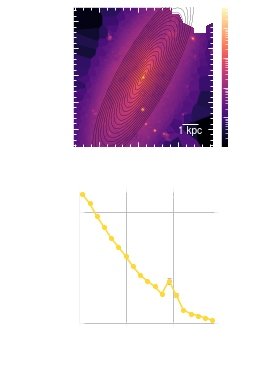

In [21]:
vorbin_wcs = gal_rp.rp_options["wcs"]
px_to_kpc = fu.calc_pc_per_px(vorbin_wcs, GALDIST)[0][0] / 1000  # assume square pixels
# 
# Plot
#
# with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer_blackTicks.mplstyle"):
with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer.mplstyle"):
    with plt.rc_context({"font.size" : 10}):  # temporaily decrease fontsizes
        fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
        ax1 = fig.add_subplot(2, 1, 1, projection=vorbin_wcs)
        #
        # Plot data
        #
        img1 = ax1.imshow(gal_rp.data, cmap="magma", norm=mpl.colors.LogNorm())
        cbar1 = fig.colorbar(img1, fraction=0.045)
        cbar1.set_label(r"$\rm \Sigma_\star$ [$\rm M_\odot\; pc^{-2}$]")
        # Mark centre
        ax1.plot(*vorbin_wcs.world_to_pixel(gal_rp.center), marker="o", color=sns.color_palette("Set2")[5], markersize=1)
        # Add annuli
        pu.add_annuli_old(
            ax1, gal_rp.annuli, ls="-", edgecolor="k", fc="None", lw=0.25, zorder=2
        )
        # Add scalebar
        pu.add_scalebar(ax1, vorbin_wcs, dist=GALDIST, color="w")
        ax1.tick_params(color="w")
        ax1.set_xlim(0, gal_rp.data.shape[1])
        ax1.set_ylim(0, gal_rp.data.shape[0])
        ax1.set_xlabel("RA (J2000)")
        ax1.set_ylabel("Dec (J2000)")
        ax1.grid(False)
        ax1.set_aspect("equal")
        #
        ax2 = fig.add_subplot(2, 1, 2)
        ebar2 = ax2.errorbar(
            x=gal_rp.radii * px_to_kpc,
            y=gal_rp.avg_data,
            yerr=gal_rp.avg_data_err,  # uncertainty in the mean/median from bootstrapping
            fmt="-o",
            markersize=4,
            color=sns.color_palette("Set2")[5],
            ecolor=sns.color_palette("Paired")[8],
            elinewidth=1,
            capsize=2,
        )
        # ebar2[-1][0].set_linestyle("--")
        # 
        # Add name of galaxy
        # 
        high_i_str = "*" if gal_rp.i >= I_THRESHOLD else ""
        ax2.text(
            0.9,
            0.9,
            re.sub(r"(\d+)", " \\1", gal_to_plot) + high_i_str,
            c="w",
            ha="right",
            transform=ax2.transAxes,
        )
        ax2.set_xlabel("Radius [kpc]")
        # ax2.set_xticks([0, 1, 2, 3, 4])
        ax2.set_xlim(left=0)
        ax2.set_ylabel(
            gal_rp.rp_options["func"].capitalize()
            + r" $\rm \Sigma_\star$ [$\rm M_\odot\; pc^{-2}$]"
        )
        ax2.semilogy()
        pu.set_aspect(ax2, 1, logy=True)
        #
        fig.tight_layout(pad=4)
        # fig.savefig(gal_to_plot_path + f"{gal_to_plot}_vorbin_SNR50_{quantity_to_plot}_radProf_fromLookupTable_{gal_n_annuli}annuli_i_corr_beamer.pdf")
        plt.show()

In [12]:
gal_drp = gal_rp.directional_radial_profile(
    angle=None,  # take direction to be along galaxy's major axis
    bootstrap_errs=True,
    bootstrap_seed=1234,
    results_to_1d=True,  # easier to plot radial profile this way
)

In [32]:
sns.color_palette("light:b")

[(0.9427942677547513, 0.942825384792593, 0.9519953287278279),
 (0.754235414203801, 0.7542603078340744, 0.9615962629822623),
 (0.5656765606528508, 0.5656952308755558, 0.9711971972366967),
 (0.3771177071019005, 0.3771301539170372, 0.9807981314911312),
 (0.18855885355095026, 0.18856507695851854, 0.9903990657455656),
 (0.0, 0.0, 1.0)]

/opt/conda/lib/python3.8/contextlib.py:113: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  return next(self.gen)
/arc/home/IsaacCheng/.local/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


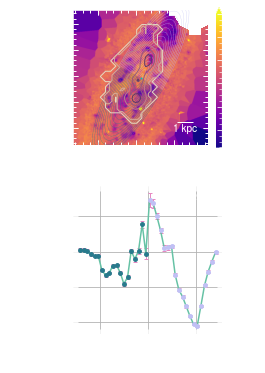

In [36]:
from matplotlib.patches import Arc
vorbin_wcs = gal_drp.rp_options["wcs"]
px_to_kpc = fu.calc_pc_per_px(vorbin_wcs, GALDIST)[0][0] / 1000  # assume square pixels
co_palette = sns.color_palette("ch:s=-.2,r=.6")
co_nyquist_color = [co_palette[0]]
co_9as_color = co_palette[1:5]
# 
# Plot DIRECTIONAL RADIAL PROFILE
#
# with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer_blackTicks.mplstyle"):
with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer.mplstyle"):
    with plt.rc_context({"font.size" : 10}):  # temporaily decrease fontsizes
        fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
        ax1 = fig.add_subplot(2, 1, 1, projection=vorbin_wcs)
        positive_color = sns.color_palette("light:b")[1]
        negative_color = sns.color_palette("crest")[3]
        #
        # Plot data
        #
        img1 = ax1.imshow(gal_drp.data, cmap="plasma", vmax=1.2)
        cbar1 = fig.colorbar(img1, fraction=0.045, extend="max")
        cbar1.set_label(r"u-g Colour")
        # Mark centre
        ax1.plot(*vorbin_wcs.world_to_pixel(gal_drp.center), marker="o", color="c", markersize=1)
        # Add annuli
        annuli = np.hstack((gal_drp.annuli[::-1], gal_drp.annuli))
        for num, annulus in enumerate(annuli):
            try:
                # EllipticalAnnulus attributes. N.B. height and width are switched from "normal"
                height = annulus.b_out
                width = annulus.a_out
            except AttributeError:
                # EllipticalAperture attributes. N.B. height and width are switched from "normal"
                height = annulus.b
                width = annulus.a
            if num >= len(annuli) / 2:
                # Positive radii annuli
                edgecolor = positive_color
                arcangle = (np.rad2deg(annulus.theta) + 180) % 360.0
            else:
                # Negative radii annuli
                edgecolor = negative_color
                arcangle = np.rad2deg(annulus.theta) % 360.0
            arc = Arc(
                xy=annulus.positions,
                width=width * 2,  # full major/minor axis
                height=height * 2,  # full major/minor axis
                angle=arcangle,
                theta1=-90,
                theta2=90,
                ls="-",
                edgecolor=edgecolor,
                alpha=1,
                lw=0.25,
                zorder=2,
            )
            ax1.add_patch(arc)
        # Add CO contours
        co_9as_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{gal_to_plot}/{gal_to_plot}_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
        co_nyquist_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/{gal_to_plot}/{gal_to_plot}_7m+tp_co21_pbcorr_9as_np_round_mom0_Kkms-1.fits"
        co_9as_data, co_9as_header = fits.getdata(co_9as_path, header=True)
        co_nyquist_data, co_nyquist_header = fits.getdata(co_nyquist_path, header=True)
        ax1.contour(
            co_nyquist_data,
            transform=ax1.get_transform(WCS(co_nyquist_header)),
            levels=0,
            colors=co_nyquist_color,
            linewidths=1,
            zorder=3,
        )
        ax1.contour(
            co_9as_data,
            transform=ax1.get_transform(WCS(co_9as_header)),
            levels=3,
            colors=co_9as_color,
            linewidths=1,
            zorder=3,
        )
        # Add scalebar
        pu.add_scalebar(ax1, vorbin_wcs, dist=GALDIST, color="w")
        ax1.set_xlim(0, gal_drp.data.shape[1])
        ax1.set_ylim(0, gal_drp.data.shape[0])
        ax1.set_xlabel("RA (J2000)")
        ax1.set_ylabel("Dec (J2000)")
        ax1.grid(False)
        ax1.set_aspect("equal")
        # ax1.tick_params(which="both", color="k")
        #
        ax2 = fig.add_subplot(2, 1, 2)
        radii = gal_drp.drp_results["radii"]
        # Plot negative radii data
        ax2.scatter(
            x=radii[radii < 0] * px_to_kpc,
            y=gal_drp.drp_results["avg_data"][radii < 0],
            c=negative_color,
            s=15,
            zorder=3,
        )
        # Plot positive radii data
        ax2.scatter(
            x=radii[radii > 0] * px_to_kpc,
            y=gal_drp.drp_results["avg_data"][radii > 0],
            c=positive_color,
            s=15,
            zorder=3,
        )
        # Plot errorbars
        ebar2 = ax2.errorbar(
            x=gal_drp.drp_results["radii"] * px_to_kpc,
            y=gal_drp.drp_results["avg_data"],
            yerr=gal_drp.drp_results["avg_data_err"],  # uncertainty from bootstrapping
            fmt="-",
            color="C0",
            ecolor="C3",
            elinewidth=1,
            capsize=2,
        )
        # 
        # Add name of galaxy
        # 
        high_i_str = "*" if gal_drp.i >= I_THRESHOLD else ""
        ax2.text(
            0.9,
            0.9,
            re.sub(r"(\d+)", " \\1", gal_to_plot) + high_i_str,
            c="w",
            ha="right",
            transform=ax2.transAxes,
        )
        ax2.set_xlabel("Radius [kpc]")
        ax2.set_ylabel(
            gal_drp.rp_options["func"].capitalize()
            + r" u-g Colour"
        )
        # ax2.set_xticks([-4, -2, 0, 2, 4])
        #
        fig.tight_layout(pad=3.5)
        # fig.savefig(gal_to_plot_path + f"{gal_to_plot}_vorbin_SNR50_{quantity_to_plot}_directionalRadProf_extinctionCorr_{gal_n_annuli}annuli_beamer.pdf")
        plt.show()

## Making radial profiles for NGC 4380 (34 annuli)


### Stellar Mass Density


In [6]:
gal_to_plot = "NGC4380"  # only do NGC4380 for now. Also do 4222 later
gal_to_plot_path = f"/arc/home/IsaacCheng/coop_f2021/galaxies/vorbin_radial_profiles/{gal_to_plot}/"
quantity_to_plot = "M_density"  # "M_density", "MLi", or "u-g"
for gal, i, pa, cen, radio_width, radio_n_annuli in zip(galaxies, inclinations, position_angles, centers, annulus_widths_arcsec, radio_n_annulis):
    if gal != gal_to_plot:
        continue
    else:
        radio_n_annuli = 4
    gal_rp, gal_n_annuli, gal_min_width_arcsec = get_vorbin_rp(
        gal, i, pa, cen, radio_width, radio_n_annuli, rp_quantity=quantity_to_plot, n_annuli=34
    )
    print(gal_n_annuli)


NGC4380 high_i_height: None
NGC4380's worst image quality is 1.13 arcsec from u-band data
INFO: Using given n_annuli (34) instead of automatically-calculated n_annuli
Min width (pixels): 6.082039986066301
34


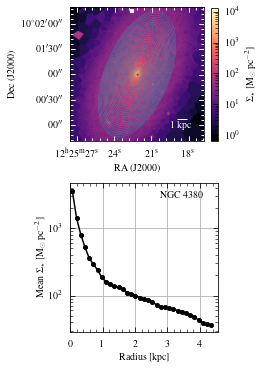

In [8]:
%matplotlib inline
vorbin_wcs = gal_rp.rp_options["wcs"]
px_to_kpc = fu.calc_pc_per_px(vorbin_wcs, GALDIST)[0][0] / 1000  # assume square pixels
# 
# Plot
#
fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
ax1 = fig.add_subplot(2, 1, 1, projection=vorbin_wcs)
#
# Plot data
#
img1 = ax1.imshow(gal_rp.data, cmap="magma", norm=mpl.colors.LogNorm())
cbar1 = fig.colorbar(img1, fraction=0.045)
cbar1.set_label(r"$\rm \Sigma_\star$ [$\rm M_\odot\; pc^{-2}$]")
# Mark centre
ax1.plot(*vorbin_wcs.world_to_pixel(gal_rp.center), "ro", markersize=1)
# Add annuli
pu.add_annuli_RadialProfile(
    ax1, gal_rp, ls="-", edgecolor="c", fc="None", lw=0.25, zorder=2, alpha_coeff=-1
)
# Add scalebar
pu.add_scalebar(ax1, vorbin_wcs, dist=GALDIST, color="w")
ax1.tick_params(color="w")
ax1.set_xlim(0, gal_rp.data.shape[1])
ax1.set_ylim(0, gal_rp.data.shape[0])
ax1.set_xlabel("RA (J2000)")
ax1.set_ylabel("Dec (J2000)")
ax1.grid(False)
ax1.set_aspect("equal")
#
ax2 = fig.add_subplot(2, 1, 2)
ebar2 = ax2.errorbar(
    x=gal_rp.radii * px_to_kpc,
    y=gal_rp.avg_data,
    yerr=gal_rp.avg_data_err,  # uncertainty in the mean/median from bootstrapping
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar2[-1][0].set_linestyle("--")
# 
# Add name of galaxy
# 
high_i_str = "*" if gal_rp.i >= I_THRESHOLD else ""
ax2.text(
    0.9,
    0.9,
    re.sub(r"(\d+)", " \\1", gal_to_plot) + high_i_str,
    c="k",
    ha="right",
    transform=ax2.transAxes,
)
ax2.set_xlabel("Radius [kpc]")
ax2.set_ylabel(
    gal_rp.rp_options["func"].capitalize()
    + r" $\rm \Sigma_\star$ [$\rm M_\odot\; pc^{-2}$]"
)
ax2.semilogy()
ax2.set_xlim(left=0)
ax2.set_xticks([0, 1, 2, 3, 4])
#
fig.tight_layout(pad=3.5)
# fig.savefig(gal_to_plot_path + f"{gal_to_plot}_vorbin_SNR50_{quantity_to_plot}_radProf_fromLookupTable_i_corr_34annuli_wtr.pdf")
plt.show()

In [9]:
#
# Average uncertainty radial profile
#
gal_to_plot = "NGC4380"  # only do NGC4380 for now. Also do 4222 later
gal_to_plot_path = f"/arc/home/IsaacCheng/coop_f2021/galaxies/vorbin_radial_profiles/{gal_to_plot}/"
quantity_to_plot = "M_density"  # "M_density", "MLi", or "u-g"
for gal, i, pa, cen, radio_width, radio_n_annuli in zip(galaxies, inclinations, position_angles, centers, annulus_widths_arcsec, radio_n_annulis):
    if gal != gal_to_plot:
        continue
    else:
        radio_n_annuli = 4
    gal_rp, gal_n_annuli, gal_min_width_arcsec = get_vorbin_uncertainty_rp(
        gal, i, pa, cen, radio_width, radio_n_annuli, rp_quantity=quantity_to_plot, n_annuli=34
    )
    print(gal_n_annuli)


NGC4380 high_i_height: None
NGC4380's worst image quality is 1.13 arcsec from u-band data
INFO: Using given n_annuli (34) instead of automatically-calculated n_annuli
Min width (pixels): 6.082039986066301
34


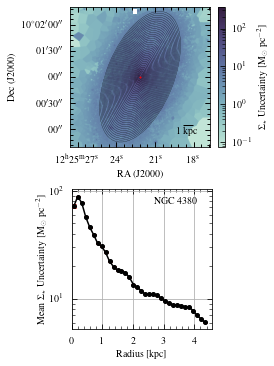

In [19]:
%matplotlib inline
vorbin_wcs = gal_rp.rp_options["wcs"]
px_to_kpc = fu.calc_pc_per_px(vorbin_wcs, GALDIST)[0][0] / 1000  # assume square pixels
# 
# Plot
#
fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
ax1 = fig.add_subplot(2, 1, 1, projection=vorbin_wcs)
#
# Plot data
#
img1 = ax1.imshow(
    gal_rp.data,
    cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True),
    norm=mpl.colors.LogNorm()
)
cbar1 = fig.colorbar(img1, fraction=0.045)
cbar1.set_label(r"$\rm \Sigma_\star$ Uncertainty [$\rm M_\odot\; pc^{-2}$]")
# Mark centre
ax1.plot(*vorbin_wcs.world_to_pixel(gal_rp.center), "ro", markersize=1)
# Add annuli
pu.add_annuli_RadialProfile(
    ax1, gal_rp, ls="-", edgecolor="k", fc="None", lw=0.25, zorder=2, alpha_coeff=-1
)
# Add scalebar
pu.add_scalebar(ax1, vorbin_wcs, dist=GALDIST)
ax1.set_xlim(0, gal_rp.data.shape[1])
ax1.set_ylim(0, gal_rp.data.shape[0])
ax1.set_xlabel("RA (J2000)")
ax1.set_ylabel("Dec (J2000)")
ax1.grid(False)
ax1.set_aspect("equal")
#
ax2 = fig.add_subplot(2, 1, 2)
ebar2 = ax2.errorbar(
    x=gal_rp.radii * px_to_kpc,
    y=gal_rp.avg_data,
    yerr=gal_rp.avg_data_err,  # uncertainty in the mean/median from bootstrapping
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar2[-1][0].set_linestyle("--")
# 
# Add name of galaxy
# 
high_i_str = "*" if gal_rp.i >= I_THRESHOLD else ""
ax2.text(
    0.9,
    0.9,
    re.sub(r"(\d+)", " \\1", gal_to_plot) + high_i_str,
    c="k",
    ha="right",
    transform=ax2.transAxes,
)
ax2.set_xlabel("Radius [kpc]")
ax2.set_ylabel(
    gal_rp.rp_options["func"].capitalize()
    + r" $\rm \Sigma_\star$ Uncertainty [$\rm M_\odot\; pc^{-2}$]"
)
ax2.semilogy()
ax2.set_xlim(left=0)
ax2.set_xticks([0, 1, 2, 3, 4])
pu.set_aspect(ax2, 1, logy=True)
#
fig.tight_layout(pad=4)
# fig.savefig(gal_to_plot_path + f"{gal_to_plot}_vorbin_SNR50_{quantity_to_plot}_unc_radProf_fromLookupTable_i_corr_34annuli_wtr.pdf")
plt.show()

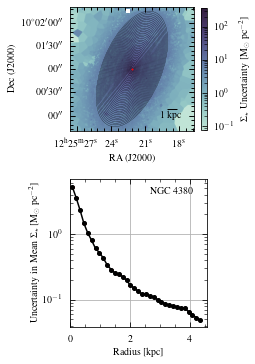

In [27]:
vorbin_wcs = gal_rp.rp_options["wcs"]
px_to_kpc = fu.calc_pc_per_px(vorbin_wcs, GALDIST)[0][0] / 1000  # assume square pixels
# 
# Plot
#
fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
ax1 = fig.add_subplot(2, 1, 1, projection=vorbin_wcs)
#
# Plot data
#
img1 = ax1.imshow(gal_rp.noise, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True), norm=mpl.colors.LogNorm())
cbar1 = fig.colorbar(img1, fraction=0.045)
cbar1.set_label(r"$\rm \Sigma_\star$ Uncertainty [$\rm M_\odot\; pc^{-2}$]")
# Mark centre
ax1.plot(*vorbin_wcs.world_to_pixel(gal_rp.center), "ro", markersize=1)
# Add annuli
pu.add_annuli_old(
    ax1, gal_rp.annuli, ls="-", edgecolor="k", fc="None", lw=0.25, zorder=2
)
# Add scalebar
pu.add_scalebar(ax1, vorbin_wcs, dist=GALDIST, color="k")
ax1.tick_params(color="k")
ax1.set_xlim(0, gal_rp.noise.shape[1])
ax1.set_ylim(0, gal_rp.noise.shape[0])
ax1.set_xlabel("RA (J2000)")
ax1.set_ylabel("Dec (J2000)")
ax1.grid(False)
ax1.set_aspect("equal")
#
ax2 = fig.add_subplot(2, 1, 2)
ebar2 = ax2.errorbar(
    x=gal_rp.radii * px_to_kpc,
    y=gal_rp.avg_noise,
    yerr=gal_rp.avg_noise_err,  # uncertainty in the mean/median from bootstrapping
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar2[-1][0].set_linestyle("--")
# 
# Add name of galaxy
# 
high_i_str = "*" if gal_rp.i >= I_THRESHOLD else ""
ax2.text(
    0.9,
    0.9,
    re.sub(r"(\d+)", " \\1", gal_to_plot) + high_i_str,
    c="k",
    ha="right",
    transform=ax2.transAxes,
)
ax2.set_xlabel("Radius [kpc]")
ax2.set_ylabel(
    "Uncertainty in "
    + gal_rp.rp_options["func"].capitalize()
    + r" $\rm \Sigma_\star$ [$\rm M_\odot\; pc^{-2}$]"
)
ax2.semilogy()
ax2.set_xlim(left=0)
#
fig.tight_layout(pad=3.5)
# fig.savefig(gal_to_plot_path + f"{gal_to_plot}_vorbin_SNR50_{quantity_to_plot}_unc_radProf_fromLookupTable_i_corr_34annuli.pdf")
plt.show()

#### Version for beamer slides


/opt/conda/lib/python3.8/contextlib.py:113: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  return next(self.gen)


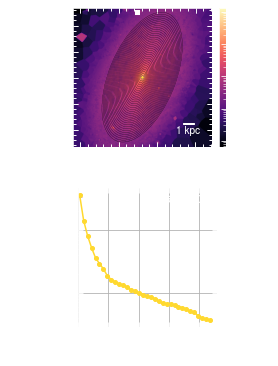

In [29]:
vorbin_wcs = gal_rp.rp_options["wcs"]
px_to_kpc = fu.calc_pc_per_px(vorbin_wcs, GALDIST)[0][0] / 1000  # assume square pixels
# 
# Plot
#
# with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer_blackTicks.mplstyle"):
with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer.mplstyle"):
    with plt.rc_context({"font.size" : 10}):  # temporaily decrease fontsizes
        fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
        ax1 = fig.add_subplot(2, 1, 1, projection=vorbin_wcs)
        #
        # Plot data
        #
        img1 = ax1.imshow(gal_rp.data, cmap="magma", norm=mpl.colors.LogNorm())
        cbar1 = fig.colorbar(img1, fraction=0.045)
        cbar1.set_label(r"$\rm \Sigma_\star$ [$\rm M_\odot\; pc^{-2}$]")
        # Mark centre
        ax1.plot(*vorbin_wcs.world_to_pixel(gal_rp.center), marker="o", color=sns.color_palette("Set2")[5], markersize=1)
        # Add annuli
        pu.add_annuli_old(
            ax1, gal_rp.annuli, ls="-", edgecolor="k", fc="None", lw=0.25, zorder=2
        )
        # Add scalebar
        pu.add_scalebar(ax1, vorbin_wcs, dist=GALDIST, color="w")
        ax1.tick_params(color="w")
        ax1.set_xlim(0, gal_rp.data.shape[1])
        ax1.set_ylim(0, gal_rp.data.shape[0])
        ax1.set_xlabel("RA (J2000)")
        ax1.set_ylabel("Dec (J2000)")
        ax1.grid(False)
        ax1.set_aspect("equal")
        #
        ax2 = fig.add_subplot(2, 1, 2)
        ebar2 = ax2.errorbar(
            x=gal_rp.radii * px_to_kpc,
            y=gal_rp.avg_data,
            yerr=gal_rp.avg_data_err,  # uncertainty in the mean/median from bootstrapping
            fmt="-o",
            markersize=4,
            color=sns.color_palette("Set2")[5],
            ecolor=sns.color_palette("Paired")[8],
            elinewidth=1,
            capsize=2,
        )
        # ebar2[-1][0].set_linestyle("--")
        # 
        # Add name of galaxy
        # 
        high_i_str = "*" if gal_rp.i >= I_THRESHOLD else ""
        ax2.text(
            0.9,
            0.9,
            re.sub(r"(\d+)", " \\1", gal_to_plot) + high_i_str,
            c="w",
            ha="right",
            transform=ax2.transAxes,
        )
        ax2.set_xlabel("Radius [kpc]")
        ax2.set_xticks([0, 1, 2, 3, 4])
        ax2.set_xlim(left=0)
        ax2.set_ylabel(
            gal_rp.rp_options["func"].capitalize()
            + r" $\rm \Sigma_\star$ [$\rm M_\odot\; pc^{-2}$]"
        )
        ax2.semilogy()
        pu.set_aspect(ax2, 1, logy=True)
        #
        fig.tight_layout(pad=4)
        # fig.savefig(gal_to_plot_path + f"{gal_to_plot}_vorbin_SNR50_{quantity_to_plot}_radProf_fromLookupTable_34annuli_i_corr_beamer.pdf")
        plt.show()

/opt/conda/lib/python3.8/contextlib.py:113: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  return next(self.gen)


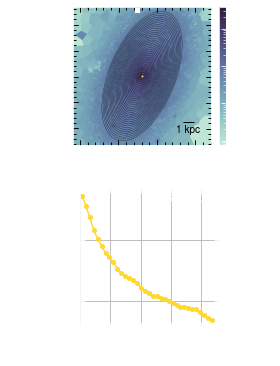

In [31]:
vorbin_wcs = gal_rp.rp_options["wcs"]
px_to_kpc = fu.calc_pc_per_px(vorbin_wcs, GALDIST)[0][0] / 1000  # assume square pixels
# 
# Plot
#
# with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer_blackTicks.mplstyle"):
with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer.mplstyle"):
    with plt.rc_context({"font.size" : 10}):  # temporaily decrease fontsizes
        fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
        ax1 = fig.add_subplot(2, 1, 1, projection=vorbin_wcs)
        #
        # Plot data
        #
        img1 = ax1.imshow(gal_rp.noise, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True), norm=mpl.colors.LogNorm())
        cbar1 = fig.colorbar(img1, fraction=0.045)
        cbar1.set_label(r"$\rm \Sigma_\star$ Uncertainty [$\rm M_\odot\; pc^{-2}$]")
        # Mark centre
        ax1.plot(*vorbin_wcs.world_to_pixel(gal_rp.center), marker="o", color=sns.color_palette("Set2")[5], markersize=1)
        # Add annuli
        pu.add_annuli_old(
            ax1, gal_rp.annuli, ls="-", edgecolor="k", fc="None", lw=0.25, zorder=2
        )
        # Add scalebar
        pu.add_scalebar(ax1, vorbin_wcs, dist=GALDIST, color="k")
        ax1.tick_params(color="k")
        ax1.set_xlim(0, gal_rp.noise.shape[1])
        ax1.set_ylim(0, gal_rp.noise.shape[0])
        ax1.set_xlabel("RA (J2000)")
        ax1.set_ylabel("Dec (J2000)")
        ax1.grid(False)
        ax1.set_aspect("equal")
        #
        ax2 = fig.add_subplot(2, 1, 2)
        ebar2 = ax2.errorbar(
            x=gal_rp.radii * px_to_kpc,
            y=gal_rp.avg_noise,
            yerr=gal_rp.avg_noise_err,  # uncertainty in the mean/median from bootstrapping
            fmt="-o",
            markersize=4,
            color=sns.color_palette("Set2")[5],
            ecolor=sns.color_palette("Paired")[8],
            elinewidth=1,
            capsize=2,
        )
        # ebar2[-1][0].set_linestyle("--")
        # 
        # Add name of galaxy
        # 
        high_i_str = "*" if gal_rp.i >= I_THRESHOLD else ""
        ax2.text(
            0.9,
            0.9,
            re.sub(r"(\d+)", " \\1", gal_to_plot) + high_i_str,
            c="w",
            ha="right",
            transform=ax2.transAxes,
        )
        ax2.set_xlabel("Radius [kpc]")
        ax2.set_xticks([0, 1, 2, 3, 4])
        ax2.set_xlim(left=0)
        ax2.set_ylabel(
            "Uncertainty in "
            + gal_rp.rp_options["func"].capitalize()
            + r" $\rm \Sigma_\star$ [$\rm M_\odot\; pc^{-2}$]"
        )
        ax2.semilogy()
        pu.set_aspect(ax2, 1, logy=True)
        #
        fig.tight_layout(pad=4)
        # fig.savefig(gal_to_plot_path + f"{gal_to_plot}_vorbin_SNR50_{quantity_to_plot}_unc_radProf_fromLookupTable_34annuli_i_corr_beamer.pdf")
        plt.show()

### u-g Colour


In [55]:
gal_to_plot = "NGC4380"  # only do NGC4380 for now. Also do 4222 later
gal_to_plot_path = f"/arc/home/IsaacCheng/coop_f2021/galaxies/vorbin_radial_profiles/{gal_to_plot}/"
quantity_to_plot = "u-g"  # "M_density", "MLi", or "u-g"
for gal, i, pa, cen, radio_width, radio_n_annuli in zip(galaxies, inclinations, position_angles, centers, annulus_widths_arcsec, radio_n_annulis):
    if gal != gal_to_plot:
        continue
    else:
        radio_n_annuli = 4
    gal_rp, gal_n_annuli, gal_min_width_arcsec = get_vorbin_rp(
        gal, i, pa, cen, radio_width, radio_n_annuli, rp_quantity=quantity_to_plot, n_annuli=34
    )
    print(gal_n_annuli)


NGC4380 high_i_height: None
NGC4380's worst image quality is 1.13 arcsec from u-band data
INFO: Using given n_annuli (34) instead of automatically-calculated n_annuli
Min width (pixels): 6.082039986066301
34


/arc/home/IsaacCheng/.local/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


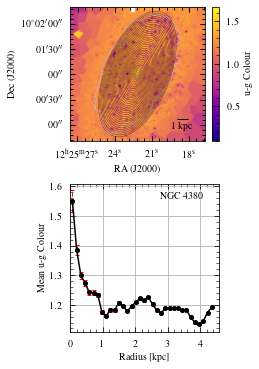

In [59]:
vorbin_wcs = gal_rp.rp_options["wcs"]
px_to_kpc = fu.calc_pc_per_px(vorbin_wcs, GALDIST)[0][0] / 1000  # assume square pixels
# 
# Plot
#
fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
ax1 = fig.add_subplot(2, 1, 1, projection=vorbin_wcs)
#
# Plot data
#
img1 = ax1.imshow(gal_rp.data, cmap="plasma")
cbar1 = fig.colorbar(img1, fraction=0.045)
cbar1.set_label(r"u-g Colour")
# Mark centre
ax1.plot(*vorbin_wcs.world_to_pixel(gal_rp.center), "o", color="C2", markersize=1, zorder=5)
# Add annuli
pu.add_annuli_old(
    ax1, gal_rp.annuli, ls="-", edgecolor="k", fc="None", lw=0.25, zorder=2
)
# Add CO contours
co_palette = sns.color_palette("ch:s=-.2,r=.6")
co_nyquist_color = [co_palette[0]]
co_9as_color = co_palette[1:5]
co_9as_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{gal_to_plot}/{gal_to_plot}_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
co_9as_data, co_9as_header = fits.getdata(co_9as_path, header=True)
ax1.contour(
    co_9as_data,
    transform=ax1.get_transform(WCS(co_9as_header)),
    levels=0,
    colors=co_9as_color,
    linewidths=1,
    zorder=1,
)
# Add scalebar
pu.add_scalebar(ax1, vorbin_wcs, dist=GALDIST, color="k")
ax1.set_xlim(0, gal_rp.data.shape[1])
ax1.set_ylim(0, gal_rp.data.shape[0])
ax1.set_xlabel("RA (J2000)")
ax1.set_ylabel("Dec (J2000)")
ax1.grid(False)
ax1.set_aspect("equal")
#
ax2 = fig.add_subplot(2, 1, 2)
ebar2 = ax2.errorbar(
    x=gal_rp.radii * px_to_kpc,
    y=gal_rp.avg_data,
    yerr=gal_rp.avg_data_err,  # uncertainty in the mean/median from bootstrapping
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar2[-1][0].set_linestyle("--")
# 
# Add name of galaxy
# 
high_i_str = "*" if gal_rp.i >= I_THRESHOLD else ""
ax2.text(
    0.9,
    0.9,
    re.sub(r"(\d+)", " \\1", gal_to_plot) + high_i_str,
    c="k",
    ha="right",
    transform=ax2.transAxes,
)
ax2.set_xlabel("Radius [kpc]")
ax2.set_ylabel(
    gal_rp.rp_options["func"].capitalize()
    + r" u-g Colour"
)
ax2.set_xlim(left=0)
ax2.set_xticks(np.arange(5))
#
fig.tight_layout(pad=3.5)
# fig.savefig(gal_to_plot_path + f"{gal_to_plot}_vorbin_SNR50_{quantity_to_plot}_radProf_extinctionCorr_34annuli_wtr.pdf")
plt.show()

#### Check that dip in u-g colour is real and not a sampling artifact


In [6]:
# 
# Randomly generate minimum widths
# 
num_radial_profiles = 50
rng = np.random.default_rng(123456)
min_widths = rng.uniform(low=0.5, high=4, size=num_radial_profiles)
n_annuli = np.ceil((gal_min_width_arcsec / min_widths) * 34).astype(int)
print(min_widths)
print(n_annuli)

[2.72779812 1.84684083 0.66605897 3.84338459 3.67117828 2.09939344
 1.48186717 2.72652081 3.93248741 3.34351125 1.56819386 2.48803835
 0.5724051  2.50585172 1.94266971 1.70850614 3.05658187 1.48605459
 0.57817061 1.37952384 1.33716026 2.6669983  3.25679462 1.50588429
 1.72122221 3.4370658  0.60448602 0.77397745 2.54694907 1.93911962
 2.61518839 1.8432242  3.58487129 3.02444409 3.30617066 3.90808909
 2.72331895 2.71218907 3.80441848 3.90364369 3.08623927 2.77107575
 1.83202507 0.50818196 2.5527379  3.13040622 1.55465974 3.62105703
 3.57931641 0.90333861]
[15 21 58 10 11 19 26 15 10 12 25 16 68 16 20 23 13 26 67 28 29 15 12 26
 23 12 64 50 16 20 15 21 11 13 12 10 15 15 11 10 13 14 21 76 16 13 25 11
 11 43]


In [7]:
# 
# Generate radial profiles (BE CAREFUL OF MEMORY USAGE!)
# 
rp_results = []
tmp_gal_idx = np.where(galaxies == gal_to_plot)[0]
gal = galaxies[tmp_gal_idx][0]
i = inclinations[tmp_gal_idx][0]
pa = position_angles[tmp_gal_idx][0]
cen = centers[tmp_gal_idx[0]]
radio_width = annulus_widths_arcsec[tmp_gal_idx[0]]
# radio_n_annuli = radio_n_annulis[tmp_gal_idx[0]]
for min_width, n_annulus in zip(min_widths, n_annuli):
    print("Random min width (arcsec):", min_width)
    print("Number of annuli:", n_annulus)
    gal_rp, gal_n_annuli, gal_min_width_arcsec = get_vorbin_rp(
        gal, i, pa, cen, radio_width, 4,
        min_width=min_width, rp_quantity="u-g", n_annuli=n_annulus
    )
    rp_results.append(gal_rp)
#     galaxy_rp = galaxy_no_rp.calc_radial_profile(
#         n_annuli=n_annulus,
#         min_width=min_width,
#         wcs=vorbin_wcs,
#         include_bad=False,
#         func="mean",
#         debug_plot=False,
#         is_radio=False,
#         bootstrap_errs=True,  # estimates standard error on the mean/median
#         n_bootstraps=100,
#         bootstrap_seed=3141592654,  # for reproducibility. Does not affect global seed  
#     )
#     rp_results.append(galaxy_rp)
print("Done radial profiles")

Random min width (arcsec): 2.7277981245062577
Number of annuli: 15
INFO: Using given n_annuli (15) instead of automatically-calculated n_annuli
Min width (pixels): 14.681926785100638


Random min width (arcsec): 1.8468408271100132
Number of annuli: 21
INFO: Using given n_annuli (21) instead of automatically-calculated n_annuli
Min width (pixels): 9.940318370250319


Random min width (arcsec): 0.6660589749944461
Number of annuli: 58
INFO: Using given n_annuli (58) instead of automatically-calculated n_annuli
Min width (pixels): 3.5849533796412


Random min width (arcsec): 3.8433845886552365
Number of annuli: 10
INFO: Using given n_annuli (10) instead of automatically-calculated n_annuli
Min width (pixels): 20.686388274364717


Random min width (arcsec): 3.6711782781109337
Number of annuli: 11
INFO: Using given n_annuli (11) instead of automatically-calculated n_annuli
Min width (pixels): 19.759516003051974


Random min width (arcsec): 2.099393441988675
Number of annuli: 19
INFO: Using given n_annuli (19) instead of automatically-calculated n_annuli
Min width (pixels): 11.299641469611048


Random min width (arcsec): 1.481867166573573
Number of annuli: 26
INFO: Using given n_annuli (26) instead of automatically-calculated n_annuli
Min width (pixels): 7.975907399238268


Random min width (arcsec): 2.7265208122341655
Number of annuli: 15
INFO: Using given n_annuli (15) instead of automatically-calculated n_annuli
Min width (pixels): 14.675051860929349


Random min width (arcsec): 3.9324874131268026
Number of annuli: 10
INFO: Using given n_annuli (10) instead of automatically-calculated n_annuli
Min width (pixels): 21.165969638353666


Random min width (arcsec): 3.343511252128001
Number of annuli: 12
INFO: Using given n_annuli (12) instead of automatically-calculated n_annuli
Min width (pixels): 17.995901884340803


Random min width (arcsec): 1.568193856859559
Number of annuli: 25
INFO: Using given n_annuli (25) instead of automatically-calculated n_annuli
Min width (pixels): 8.440546675507408


Random min width (arcsec): 2.4880383515519546
Number of annuli: 16
INFO: Using given n_annuli (16) instead of automatically-calculated n_annuli
Min width (pixels): 13.3914590628367


Random min width (arcsec): 0.5724051029779466
Number of annuli: 68
INFO: Using given n_annuli (68) instead of automatically-calculated n_annuli
Min width (pixels): 3.0808767473807697


Random min width (arcsec): 2.5058517237011957
Number of annuli: 16
INFO: Using given n_annuli (16) instead of automatically-calculated n_annuli
Min width (pixels): 13.487336621861802


Random min width (arcsec): 1.9426697113981004
Number of annuli: 20
INFO: Using given n_annuli (20) instead of automatically-calculated n_annuli
Min width (pixels): 10.45610164994967


Random min width (arcsec): 1.7085061390812857
Number of annuli: 23
INFO: Using given n_annuli (23) instead of automatically-calculated n_annuli
Min width (pixels): 9.19575456135587


Random min width (arcsec): 3.0565818731472985
Number of annuli: 13
INFO: Using given n_annuli (13) instead of automatically-calculated n_annuli
Min width (pixels): 16.45155148067903


Random min width (arcsec): 1.486054592217519
Number of annuli: 26
INFO: Using given n_annuli (26) instead of automatically-calculated n_annuli
Min width (pixels): 7.9984455321631875


Random min width (arcsec): 0.5781706059308687
Number of annuli: 67
INFO: Using given n_annuli (67) instead of automatically-calculated n_annuli
Min width (pixels): 3.1119086230440045


Random min width (arcsec): 1.379523842622107
Number of annuli: 28
INFO: Using given n_annuli (28) instead of automatically-calculated n_annuli
Min width (pixels): 7.4250612146544155


Random min width (arcsec): 1.3371602571716568
Number of annuli: 29
INFO: Using given n_annuli (29) instead of automatically-calculated n_annuli
Min width (pixels): 7.197046152120986


Random min width (arcsec): 2.6669983003035074
Number of annuli: 15
INFO: Using given n_annuli (15) instead of automatically-calculated n_annuli
Min width (pixels): 14.35468168603256


Random min width (arcsec): 3.2567946194117314
Number of annuli: 12
INFO: Using given n_annuli (12) instead of automatically-calculated n_annuli
Min width (pixels): 17.5291638067856


Random min width (arcsec): 1.505884286080161
Number of annuli: 26
INFO: Using given n_annuli (26) instead of automatically-calculated n_annuli
Min width (pixels): 8.105175612680037


Random min width (arcsec): 1.721222211768353
Number of annuli: 23
INFO: Using given n_annuli (23) instead of automatically-calculated n_annuli
Min width (pixels): 9.264196740602303


Random min width (arcsec): 3.437065803693483
Number of annuli: 12
INFO: Using given n_annuli (12) instead of automatically-calculated n_annuli
Min width (pixels): 18.499443940535283


Random min width (arcsec): 0.6044860226942116
Number of annuli: 64
INFO: Using given n_annuli (64) instead of automatically-calculated n_annuli
Min width (pixels): 3.2535470451720143


Random min width (arcsec): 0.7739774500281803
Number of annuli: 50
INFO: Using given n_annuli (50) instead of automatically-calculated n_annuli
Min width (pixels): 4.165806902110641


Random min width (arcsec): 2.5469490748854358
Number of annuli: 16
INFO: Using given n_annuli (16) instead of automatically-calculated n_annuli
Min width (pixels): 13.708536385776808


Random min width (arcsec): 1.9391196176990078
Number of annuli: 20
INFO: Using given n_annuli (20) instead of automatically-calculated n_annuli
Min width (pixels): 10.43699385186811


Random min width (arcsec): 2.615188387939703
Number of annuli: 15
INFO: Using given n_annuli (15) instead of automatically-calculated n_annuli
Min width (pixels): 14.075823315527028


Random min width (arcsec): 1.843224203928915
Number of annuli: 21
INFO: Using given n_annuli (21) instead of automatically-calculated n_annuli
Min width (pixels): 9.920852488124678


Random min width (arcsec): 3.584871294227944
Number of annuli: 11
INFO: Using given n_annuli (11) instead of automatically-calculated n_annuli
Min width (pixels): 19.29498279327045


Random min width (arcsec): 3.0244440917775806
Number of annuli: 13
INFO: Using given n_annuli (13) instead of automatically-calculated n_annuli
Min width (pixels): 16.278575134347985


Random min width (arcsec): 3.306170661664315
Number of annuli: 12
INFO: Using given n_annuli (12) instead of automatically-calculated n_annuli
Min width (pixels): 17.79492226991296


Random min width (arcsec): 3.908089087225467
Number of annuli: 10
INFO: Using given n_annuli (10) instead of automatically-calculated n_annuli
Min width (pixels): 21.034649643906764


Random min width (arcsec): 2.7233189504697264
Number of annuli: 15
INFO: Using given n_annuli (15) instead of automatically-calculated n_annuli
Min width (pixels): 14.657818364220343


Random min width (arcsec): 2.712189065696156
Number of annuli: 15
INFO: Using given n_annuli (15) instead of automatically-calculated n_annuli
Min width (pixels): 14.597913581713117


Random min width (arcsec): 3.8044184751298022
Number of annuli: 11
INFO: Using given n_annuli (11) instead of automatically-calculated n_annuli
Min width (pixels): 20.476659548202512


Random min width (arcsec): 3.903643694025298
Number of annuli: 10
INFO: Using given n_annuli (10) instead of automatically-calculated n_annuli
Min width (pixels): 21.010723042847278


Random min width (arcsec): 3.0862392683725677
Number of annuli: 13
INFO: Using given n_annuli (13) instead of automatically-calculated n_annuli
Min width (pixels): 16.611177554699083


Random min width (arcsec): 2.7710757472164267
Number of annuli: 14
INFO: Using given n_annuli (14) instead of automatically-calculated n_annuli
Min width (pixels): 14.914861503529965


Random min width (arcsec): 1.832025067784854
Number of annuli: 21
INFO: Using given n_annuli (21) instead of automatically-calculated n_annuli
Min width (pixels): 9.860574971454254


Random min width (arcsec): 0.508181959706826
Number of annuli: 76
INFO: Using given n_annuli (76) instead of automatically-calculated n_annuli
Min width (pixels): 2.7352061939242915


Random min width (arcsec): 2.5527379045057663
Number of annuli: 16
INFO: Using given n_annuli (16) instead of automatically-calculated n_annuli
Min width (pixels): 13.739693813408115


Random min width (arcsec): 3.1304062174282437
Number of annuli: 13
INFO: Using given n_annuli (13) instead of automatically-calculated n_annuli
Min width (pixels): 16.848898926574456


Random min width (arcsec): 1.5546597357873622
Number of annuli: 25
INFO: Using given n_annuli (25) instead of automatically-calculated n_annuli
Min width (pixels): 8.367701484766378


Random min width (arcsec): 3.621057031937481
Number of annuli: 11
INFO: Using given n_annuli (11) instead of automatically-calculated n_annuli
Min width (pixels): 19.48974660183214


Random min width (arcsec): 3.5793164086327183
Number of annuli: 11
INFO: Using given n_annuli (11) instead of automatically-calculated n_annuli
Min width (pixels): 19.265084531050814


Random min width (arcsec): 0.9033386064214615
Number of annuli: 43
INFO: Using given n_annuli (43) instead of automatically-calculated n_annuli
Min width (pixels): 4.862072146205962


Done radial profiles


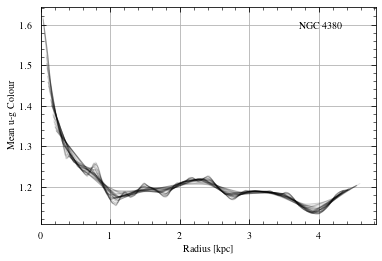

In [9]:
fig, ax = plt.subplots()
for rp_result in rp_results:
    ebar = ax.errorbar(
        x=rp_result.radii * px_to_kpc,
        y=rp_result.avg_data,
    #     yerr=galaxy_rp.avg_data_err,  # uncertainty in the mean/median from bootstrapping
        fmt="-",
        color="k",
        alpha=0.1,
        lw=1,
    #     ecolor="r",
    #     elinewidth=1,
    #     capsize=2,
    )
# ebar2[-1][0].set_linestyle("--")
# 
# Add name of galaxy
# 
high_i_str = "*" if gal_rp.i >= I_THRESHOLD else ""
ax.text(
    0.9,
    0.9,
    re.sub(r"(\d+)", " \\1", gal_to_plot) + high_i_str,
    c="k",
    ha="right",
    transform=ax.transAxes,
)
# 
# Other parameters
# 
ax.set_xlim(left=0)
ax.set_xlabel("Radius [kpc]")
ax.set_ylabel(
    rp_results[0].rp_options["func"].capitalize() + " u-g Colour"
)
# fig.savefig(gal_to_plot_path + f"{gal_to_plot}_vorbin_SNR50_{quantity_to_plot}_{num_radial_profiles}radProfs_extinctionCorr_34annuli.pdf")
plt.show()

In [81]:
#
# u-g Colour Uncertainty
#
gal_to_plot = "NGC4380"  # only do NGC4380 for now. Also do 4222 later
gal_to_plot_path = f"/arc/home/IsaacCheng/coop_f2021/galaxies/vorbin_radial_profiles/{gal_to_plot}/"
quantity_to_plot = "u-g"  # "M_density", "MLi", or "u-g"
for gal, i, pa, cen, radio_width, radio_n_annuli in zip(galaxies, inclinations, position_angles, centers, annulus_widths_arcsec, radio_n_annulis):
    if gal != gal_to_plot:
        continue
    else:
        radio_n_annuli = 4
    gal_rp, gal_n_annuli, gal_min_width_arcsec = get_vorbin_uncertainty_rp(
        gal, i, pa, cen, radio_width, radio_n_annuli, rp_quantity=quantity_to_plot, n_annuli=34
    )
    print(gal_n_annuli)


NGC4380 high_i_height: None
NGC4380's worst image quality is 1.13 arcsec from u-band data
INFO: Using given n_annuli (34) instead of automatically-calculated n_annuli
Min width (pixels): 6.082039986066301
34


/arc/home/IsaacCheng/.local/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


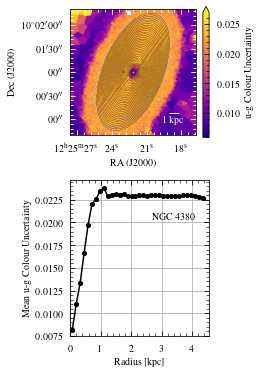

In [82]:
vorbin_wcs = gal_rp.rp_options["wcs"]
px_to_kpc = fu.calc_pc_per_px(vorbin_wcs, GALDIST)[0][0] / 1000  # assume square pixels
# 
# Plot
#
fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
ax1 = fig.add_subplot(2, 1, 1, projection=vorbin_wcs)
#
# Plot data
#
img1 = ax1.imshow(gal_rp.data, cmap="plasma", vmax=np.percentile(gal_rp.data[np.isfinite(gal_rp.data)], 99))
cbar1 = fig.colorbar(img1, fraction=0.045, extend="max")
cbar1.set_label(r"u-g Colour Uncertainty")
# Mark centre
ax1.plot(*vorbin_wcs.world_to_pixel(gal_rp.center), "o", color="C2", markersize=1, zorder=5)
# Add annuli
pu.add_annuli_old(
    ax1, gal_rp.annuli, ls="-", edgecolor="k", fc="None", lw=0.25, zorder=2
)
# Add CO contours
co_palette = sns.color_palette("ch:s=-.2,r=.6")
co_nyquist_color = [co_palette[0]]
co_9as_color = co_palette[1:5]
co_9as_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{gal_to_plot}/{gal_to_plot}_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
co_9as_data, co_9as_header = fits.getdata(co_9as_path, header=True)
ax1.contour(
    co_9as_data,
    transform=ax1.get_transform(WCS(co_9as_header)),
    levels=0,
    colors=co_9as_color,
    linewidths=1,
    zorder=1,
)
# Add scalebar
pu.add_scalebar(ax1, vorbin_wcs, dist=GALDIST, color="w")
ax1.set_xlim(0, gal_rp.data.shape[1])
ax1.set_ylim(0, gal_rp.data.shape[0])
ax1.set_xlabel("RA (J2000)")
ax1.set_ylabel("Dec (J2000)")
ax1.grid(False)
ax1.set_aspect("equal")
ax1.tick_params(which="both", color="w")
#
ax2 = fig.add_subplot(2, 1, 2)
ebar2 = ax2.errorbar(
    x=gal_rp.radii * px_to_kpc,
    y=gal_rp.avg_data,
    yerr=gal_rp.avg_data_err,  # uncertainty in the mean/median from bootstrapping
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar2[-1][0].set_linestyle("--")
# 
# Add name of galaxy
# 
high_i_str = "*" if gal_rp.i >= I_THRESHOLD else ""
ax2.text(
    0.9,
    0.75,
    re.sub(r"(\d+)", " \\1", gal_to_plot) + high_i_str,
    c="k",
    ha="right",
    transform=ax2.transAxes,
)
ax2.set_xlabel("Radius [kpc]")
ax2.set_ylabel(
    gal_rp.rp_options["func"].capitalize()
    + r" u-g Colour Uncertainty"
)
ax2.set_xlim(left=0)
ax2.set_xticks(np.arange(5))
# ax2.set_ylim(0.021, 0.0250)
ax2.set_ylim(bottom=0.0075)
#
fig.tight_layout(pad=3)
# fig.savefig(gal_to_plot_path + f"{gal_to_plot}_vorbin_SNR50_{quantity_to_plot}_unc_radProf_extinctionCorr_34annuli_wtr.pdf")
plt.show()

#### Directional Radial Profiles


In [6]:
#
# u-g Colour
#
gal_to_plot = "NGC4380"
gal_to_plot_path = f"/arc/home/IsaacCheng/coop_f2021/galaxies/vorbin_radial_profiles/{gal_to_plot}/"
quantity_to_plot = "u-g"  # "M_density", "MLi", or "u-g"
for gal, i, pa, cen, radio_width, radio_n_annuli in zip(galaxies, inclinations, position_angles, centers, annulus_widths_arcsec, radio_n_annulis):
    if gal != gal_to_plot:
        continue
    else:
        radio_n_annuli = 4
    gal_rp, gal_n_annuli, gal_min_width_arcsec = get_vorbin_rp(
        gal, i, pa, cen, radio_width, radio_n_annuli, rp_quantity=quantity_to_plot, n_annuli=34
    )
    print(gal_n_annuli)
#
gal_drp = gal_rp.directional_radial_profile(
    angle=None,  # take direction to be along galaxy's major axis
    bootstrap_errs=True,
    bootstrap_seed=1234,
    results_to_1d=True,  # easier to plot radial profile this way
)

NGC4380 high_i_height: None
NGC4380's worst image quality is 1.13 arcsec from u-band data
INFO: Using given n_annuli (34) instead of automatically-calculated n_annuli
Min width (pixels): 6.082039986066301
34


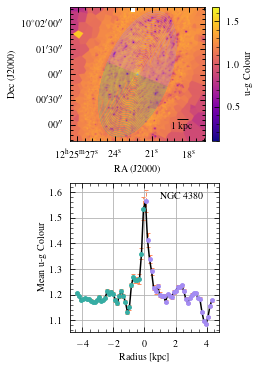

In [74]:
from matplotlib.patches import Arc
vorbin_wcs = gal_drp.rp_options["wcs"]
px_to_kpc = fu.calc_pc_per_px(vorbin_wcs, GALDIST)[0][0] / 1000  # assume square pixels
co_palette = sns.color_palette("ch:s=-.2,r=.6")
co_nyquist_color = [co_palette[0]]
co_9as_color = co_palette[1:5]
# 
# Plot DIRECTIONAL RADIAL PROFILE
#
fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
ax1 = fig.add_subplot(2, 1, 1, projection=vorbin_wcs)
positive_color = sns.color_palette("husl", 8)[6]
negative_color = sns.color_palette("husl", 8)[4]
#
# Plot data
#
img1 = ax1.imshow(gal_drp.data, cmap="plasma")
cbar1 = fig.colorbar(img1, fraction=0.045)
cbar1.set_label("u-g Colour")
# Mark centre
ax1.plot(*vorbin_wcs.world_to_pixel(gal_drp.center), marker="o", color="C2", markersize=1)
# Add annuli
annuli = np.hstack((gal_drp.annuli[::-1], gal_drp.annuli))
for num, annulus in enumerate(annuli):
    try:
        # EllipticalAnnulus attributes. N.B. height and width are switched from "normal"
        height = annulus.b_out
        width = annulus.a_out
    except AttributeError:
        # EllipticalAperture attributes. N.B. height and width are switched from "normal"
        height = annulus.b
        width = annulus.a
    if num >= len(annuli) / 2:
        # Positive radii annuli
        edgecolor = positive_color
        arcangle = (np.rad2deg(annulus.theta) + 180) % 360.0
    else:
        # Negative radii annuli
        edgecolor = negative_color
        arcangle = np.rad2deg(annulus.theta) % 360.0
    arc = Arc(
        xy=annulus.positions,
        width=width * 2,  # full major/minor axis
        height=height * 2,  # full major/minor axis
        angle=arcangle,
        theta1=-90,
        theta2=90,
        ls="-",
        edgecolor=edgecolor,
        alpha=1,
        lw=0.25,
        zorder=2,
    )
    ax1.add_patch(arc)
# Add scalebar
pu.add_scalebar(ax1, vorbin_wcs, dist=GALDIST, color="k")
ax1.set_xlim(0, gal_drp.data.shape[1])
ax1.set_ylim(0, gal_drp.data.shape[0])
ax1.set_xlabel("RA (J2000)")
ax1.set_ylabel("Dec (J2000)")
ax1.grid(False)
ax1.set_aspect("equal")
# ax1.tick_params(which="both", color="k")
#
ax2 = fig.add_subplot(2, 1, 2)
radii = gal_drp.drp_results["radii"]
# Plot negative radii data
ax2.scatter(
    x=radii[radii < 0] * px_to_kpc,
    y=gal_drp.drp_results["avg_data"][radii < 0],
    color=negative_color,
    s=15,
    zorder=3,
)
# Plot positive radii data
ax2.scatter(
    x=radii[radii > 0] * px_to_kpc,
    y=gal_drp.drp_results["avg_data"][radii > 0],
    color=positive_color,
    s=15,
    zorder=3,
)
# Plot errorbars
ebar2 = ax2.errorbar(
    x=gal_drp.drp_results["radii"] * px_to_kpc,
    y=gal_drp.drp_results["avg_data"],
    yerr=gal_drp.drp_results["avg_data_err"],  # uncertainty from bootstrapping
    fmt="-",
    color="k",
    ecolor="C1",
    elinewidth=1,
    capsize=2,
)
ebar2[-1][0].set_linestyle("--")
# 
# Add name of galaxy
# 
high_i_str = "*" if gal_drp.i >= I_THRESHOLD else ""
ax2.text(
    0.9,
    0.9,
    re.sub(r"(\d+)", " \\1", gal_to_plot) + high_i_str,
    c="k",
    ha="right",
    transform=ax2.transAxes,
)
ax2.set_xlabel("Radius [kpc]")
ax2.set_ylabel(
    gal_drp.rp_options["func"].capitalize()
    + r" u-g Colour"
)
ax2.set_xticks([-4, -2, 0, 2, 4])
#
fig.tight_layout(pad=3.5)
# fig.savefig(gal_to_plot_path + f"{gal_to_plot}_vorbin_SNR50_{quantity_to_plot}_directionalRadProf_extinctionCorr_34annuli_noPlotAnnuli_wtr.pdf")
plt.show()

In [75]:
#
# u-g Colour Uncertainty
#
gal_to_plot = "NGC4380"
gal_to_plot_path = f"/arc/home/IsaacCheng/coop_f2021/galaxies/vorbin_radial_profiles/{gal_to_plot}/"
quantity_to_plot = "u-g"  # "M_density", "MLi", or "u-g"
for gal, i, pa, cen, radio_width, radio_n_annuli in zip(galaxies, inclinations, position_angles, centers, annulus_widths_arcsec, radio_n_annulis):
    if gal != gal_to_plot:
        continue
    else:
        radio_n_annuli = 4
    gal_rp, gal_n_annuli, gal_min_width_arcsec = get_vorbin_uncertainty_rp(
        gal, i, pa, cen, radio_width, radio_n_annuli, rp_quantity=quantity_to_plot, n_annuli=34
    )
    print(gal_n_annuli)
#
gal_drp = gal_rp.directional_radial_profile(
    angle=None,  # take direction to be along galaxy's major axis
    bootstrap_errs=True,
    bootstrap_seed=1234,
    results_to_1d=True,  # easier to plot radial profile this way
)

NGC4380 high_i_height: None
NGC4380's worst image quality is 1.13 arcsec from u-band data
INFO: Using given n_annuli (34) instead of automatically-calculated n_annuli
Min width (pixels): 6.082039986066301
34


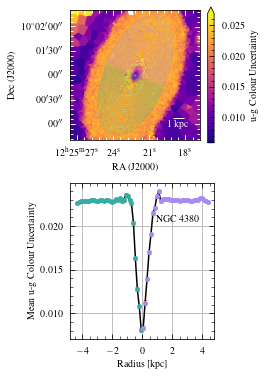

In [80]:
from matplotlib.patches import Arc
vorbin_wcs = gal_drp.rp_options["wcs"]
px_to_kpc = fu.calc_pc_per_px(vorbin_wcs, GALDIST)[0][0] / 1000  # assume square pixels
co_palette = sns.color_palette("ch:s=-.2,r=.6")
co_nyquist_color = [co_palette[0]]
co_9as_color = co_palette[1:5]
# 
# Plot DIRECTIONAL RADIAL PROFILE
#
fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
ax1 = fig.add_subplot(2, 1, 1, projection=vorbin_wcs)
positive_color = sns.color_palette("husl", 8)[6]
negative_color = sns.color_palette("husl", 8)[4]
#
# Plot data
#
img1 = ax1.imshow(gal_drp.data, cmap="plasma", vmax=np.percentile(gal_drp.data[np.isfinite(gal_drp.data)], 99))
cbar1 = fig.colorbar(img1, fraction=0.045, extend="max")
cbar1.set_label("u-g Colour Uncertainty")
# Mark centre
ax1.plot(*vorbin_wcs.world_to_pixel(gal_drp.center), marker="o", color="C2", markersize=1)
# Add annuli
annuli = np.hstack((gal_drp.annuli[::-1], gal_drp.annuli))
for num, annulus in enumerate(annuli):
    try:
        # EllipticalAnnulus attributes. N.B. height and width are switched from "normal"
        height = annulus.b_out
        width = annulus.a_out
    except AttributeError:
        # EllipticalAperture attributes. N.B. height and width are switched from "normal"
        height = annulus.b
        width = annulus.a
    if num >= len(annuli) / 2:
        # Positive radii annuli
        edgecolor = positive_color
        arcangle = (np.rad2deg(annulus.theta) + 180) % 360.0
    else:
        # Negative radii annuli
        edgecolor = negative_color
        arcangle = np.rad2deg(annulus.theta) % 360.0
    arc = Arc(
        xy=annulus.positions,
        width=width * 2,  # full major/minor axis
        height=height * 2,  # full major/minor axis
        angle=arcangle,
        theta1=-90,
        theta2=90,
        ls="-",
        edgecolor=edgecolor,
        alpha=1,
        lw=0.25,
        zorder=2,
    )
    ax1.add_patch(arc)
# Add scalebar
pu.add_scalebar(ax1, vorbin_wcs, dist=GALDIST, color="w")
ax1.set_xlim(0, gal_drp.data.shape[1])
ax1.set_ylim(0, gal_drp.data.shape[0])
ax1.set_xlabel("RA (J2000)")
ax1.set_ylabel("Dec (J2000)")
ax1.grid(False)
ax1.set_aspect("equal")
ax1.tick_params(which="both", color="w")
#
ax2 = fig.add_subplot(2, 1, 2)
radii = gal_drp.drp_results["radii"]
# Plot negative radii data
ax2.scatter(
    x=radii[radii < 0] * px_to_kpc,
    y=gal_drp.drp_results["avg_data"][radii < 0],
    color=negative_color,
    s=15,
    zorder=3,
)
# Plot positive radii data
ax2.scatter(
    x=radii[radii > 0] * px_to_kpc,
    y=gal_drp.drp_results["avg_data"][radii > 0],
    color=positive_color,
    s=15,
    zorder=3,
)
# Plot errorbars
ebar2 = ax2.errorbar(
    x=gal_drp.drp_results["radii"] * px_to_kpc,
    y=gal_drp.drp_results["avg_data"],
    yerr=gal_drp.drp_results["avg_data_err"],  # uncertainty from bootstrapping
    fmt="-",
    color="k",
    ecolor="C1",
    elinewidth=1,
    capsize=2,
)
ebar2[-1][0].set_linestyle("--")
# 
# Add name of galaxy
# 
high_i_str = "*" if gal_drp.i >= I_THRESHOLD else ""
ax2.text(
    0.9,
    0.75,
    re.sub(r"(\d+)", " \\1", gal_to_plot) + high_i_str,
    c="k",
    ha="right",
    transform=ax2.transAxes,
)
ax2.set_xlabel("Radius [kpc]")
ax2.set_ylabel(
    gal_drp.rp_options["func"].capitalize()
    + r" u-g Colour Uncertainty"
)
ax2.set_xticks([-4, -2, 0, 2, 4])
#
fig.tight_layout(pad=3)
# fig.savefig(gal_to_plot_path + f"{gal_to_plot}_vorbin_SNR50_{quantity_to_plot}_unc_directionalRadProf_extinctionCorr_34annuli_noPlotAnnuli_wtr.pdf")
plt.show()

#### Versions for beamer slides


/opt/conda/lib/python3.8/contextlib.py:113: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  return next(self.gen)


[0.10694892580389928, 1.0054974399727816, 2.824015426083145]


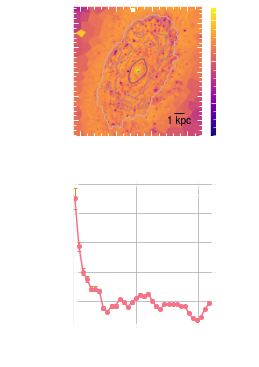

In [39]:
vorbin_wcs = gal_rp.rp_options["wcs"]
px_to_kpc = fu.calc_pc_per_px(vorbin_wcs, GALDIST)[0][0] / 1000  # assume square pixels
co_palette = sns.color_palette("ch:s=-.2,r=.6")
co_nyquist_color = [co_palette[0]]
co_9as_color = co_palette[1:5]
# 
# Plot
#
# with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer_blackTicks.mplstyle"):
with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer.mplstyle"):
    with plt.rc_context({"font.size" : 10}):  # temporaily decrease fontsizes
        fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
        ax1 = fig.add_subplot(2, 1, 1, projection=vorbin_wcs)
        #
        # Plot data
        #
        img1 = ax1.imshow(gal_rp.data, cmap="plasma")
        cbar1 = fig.colorbar(img1, fraction=0.045)
        cbar1.set_label(r"u-g Colour")
        # Mark centre
        ax1.plot(*vorbin_wcs.world_to_pixel(gal_rp.center), "co", markersize=1)
        # Add annuli
        # pu.add_annuli_old(
        #     ax1, gal_rp.annuli, ls="-", edgecolor="c", fc="None", lw=0.25, zorder=2
        # )
        # Add CO contours
        co_9as_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{gal_to_plot}/{gal_to_plot}_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
        co_nyquist_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/{gal_to_plot}/{gal_to_plot}_7m+tp_co21_pbcorr_9as_np_round_mom0_Kkms-1.fits"
        co_9as_data, co_9as_header = fits.getdata(co_9as_path, header=True)
        co_nyquist_data, co_nyquist_header = fits.getdata(co_nyquist_path, header=True)
        # ax1.contour(
        #     co_nyquist_data,
        #     transform=ax1.get_transform(WCS(co_nyquist_header)),
        #     levels=0,
        #     colors=co_nyquist_color,
        #     linewidths=1,
        #     zorder=3,
        # )
#         with open("/arc/home/IsaacCheng/coop_f2021/galaxies/gas_fraction/gas_fraction_i_corr_NGVS-VERTICO_noNorm.pkl", "rb") as f:
#             file = dill.load(f)
#             gas_frac_rps = file["radial_profiles"]
#             galaxy_names = file["galaxies"]
#             file = None  # free memory
#         print(np.where(galaxy_names == "NGC4380"))
#         gas_frac_rp = gas_frac_rps[np.where(galaxy_names == "NGC4380")[0][0]]
        co_9as_data_all_finite = co_9as_data[co_9as_data > 0]
        contour_levels = [np.percentile(co_9as_data_all_finite, 0), np.percentile(co_9as_data_all_finite, 50), np.percentile(co_9as_data_all_finite, 95)]
        print(contour_levels)
        ax1.contour(
            co_9as_data,
            transform=ax1.get_transform(WCS(co_9as_header)),
            levels=contour_levels,
            colors=co_9as_color,
            linewidths=1,
            zorder=3,
        )
        # Add scalebar
        pu.add_scalebar(ax1, vorbin_wcs, dist=GALDIST, color="k")
        ax1.set_xlim(0, gal_rp.data.shape[1])
        ax1.set_ylim(0, gal_rp.data.shape[0])
        ax1.set_xlabel("RA (J2000)")
        ax1.set_ylabel("Dec (J2000)")
        ax1.grid(False)
        ax1.set_aspect("equal")
        #
        ax2 = fig.add_subplot(2, 1, 2)
        ebar2 = ax2.errorbar(
            x=gal_rp.radii * px_to_kpc,
            y=gal_rp.avg_data,
            yerr=gal_rp.avg_data_err,  # uncertainty in the mean/median from bootstrapping
            fmt="-o",
            markersize=4,
            color=sns.color_palette("husl", 8)[0],
            ecolor=sns.color_palette("husl", 8)[1],
            elinewidth=1,
            capsize=2,
        )
        # ebar2[-1][0].set_linestyle("--")
        # 
        # Add name of galaxy
        # 
        high_i_str = "*" if gal_rp.i >= I_THRESHOLD else ""
        ax2.text(
            0.9,
            0.9,
            re.sub(r"(\d+)", " \\1", gal_to_plot) + high_i_str,
            c="w",
            ha="right",
            transform=ax2.transAxes,
        )
        ax2.set_xlabel("Radius [kpc]")
        ax2.set_ylabel(
            gal_rp.rp_options["func"].capitalize()
            + r" u-g Colour"
        )
        ax2.set_xlim(left=0)
        #
        fig.tight_layout(pad=3.5)
        # fig.savefig(gal_to_plot_path + f"{gal_to_plot}_vorbin_SNR50_{quantity_to_plot}_radProf_extinctionCorr_34annuli_noPlotAnnuli2_beamer.pdf")
        plt.show()

##### Directional Radial Profile


In [6]:
gal_drp = gal_rp.directional_radial_profile(
    angle=None,  # take direction to be along galaxy's major axis
    bootstrap_errs=True,
    bootstrap_seed=1234,
    results_to_1d=True,  # easier to plot radial profile this way
)

/opt/conda/lib/python3.8/contextlib.py:113: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  return next(self.gen)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


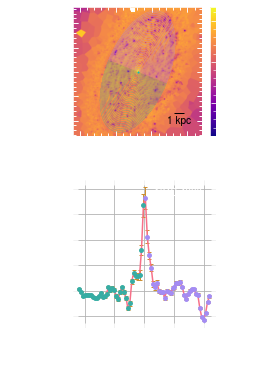

In [12]:
from matplotlib.patches import Arc
vorbin_wcs = gal_drp.rp_options["wcs"]
px_to_kpc = fu.calc_pc_per_px(vorbin_wcs, GALDIST)[0][0] / 1000  # assume square pixels
co_palette = sns.color_palette("ch:s=-.2,r=.6")
co_nyquist_color = [co_palette[0]]
co_9as_color = co_palette[1:5]
# 
# Plot DIRECTIONAL RADIAL PROFILE
#
# with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer_blackTicks.mplstyle"):
with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer.mplstyle"):
    with plt.rc_context({"font.size" : 10}):  # temporaily decrease fontsizes
        fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
        ax1 = fig.add_subplot(2, 1, 1, projection=vorbin_wcs)
        # positive_color = "C1"
        # negative_color = "C5"
        positive_color = sns.color_palette("husl", 8)[6]
        negative_color = sns.color_palette("husl", 8)[4]
        #
        # Plot data
        #
        img1 = ax1.imshow(gal_drp.data, cmap="plasma")
        cbar1 = fig.colorbar(img1, fraction=0.045)
        cbar1.set_label(r"u-g Colour")
        # Mark centre
        ax1.plot(*vorbin_wcs.world_to_pixel(gal_drp.center), marker="o", color="c", markersize=1)
        # Add annuli
        annuli = np.hstack((gal_drp.annuli[::-1], gal_drp.annuli))
        for num, annulus in enumerate(annuli):
            try:
                # EllipticalAnnulus attributes. N.B. height and width are switched from "normal"
                height = annulus.b_out
                width = annulus.a_out
            except AttributeError:
                # EllipticalAperture attributes. N.B. height and width are switched from "normal"
                height = annulus.b
                width = annulus.a
            if num >= len(annuli) / 2:
                # Positive radii annuli
                edgecolor = positive_color
                arcangle = (np.rad2deg(annulus.theta) + 180) % 360.0
            else:
                # Negative radii annuli
                edgecolor = negative_color
                arcangle = np.rad2deg(annulus.theta) % 360.0
            arc = Arc(
                xy=annulus.positions,
                width=width * 2,  # full major/minor axis
                height=height * 2,  # full major/minor axis
                angle=arcangle,
                theta1=-90,
                theta2=90,
                ls="-",
                edgecolor=edgecolor,
                alpha=1,
                lw=0.25,
                zorder=2,
            )
            ax1.add_patch(arc)
        # # Add CO contours
        # co_9as_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{gal_to_plot}/{gal_to_plot}_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
        # co_nyquist_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/{gal_to_plot}/{gal_to_plot}_7m+tp_co21_pbcorr_9as_np_round_mom0_Kkms-1.fits"
        # co_9as_data, co_9as_header = fits.getdata(co_9as_path, header=True)
        # co_nyquist_data, co_nyquist_header = fits.getdata(co_nyquist_path, header=True)
        # ax1.contour(
        #     co_nyquist_data,
        #     transform=ax1.get_transform(WCS(co_nyquist_header)),
        #     levels=0,
        #     colors=co_nyquist_color,
        #     linewidths=1,
        #     zorder=3,
        # )
        # ax1.contour(
        #     co_9as_data,
        #     transform=ax1.get_transform(WCS(co_9as_header)),
        #     levels=3,
        #     colors=co_9as_color,
        #     linewidths=1,
        #     zorder=3,
        # )
        # Add scalebar
        pu.add_scalebar(ax1, vorbin_wcs, dist=GALDIST, color="k")
        ax1.set_xlim(0, gal_drp.data.shape[1])
        ax1.set_ylim(0, gal_drp.data.shape[0])
        ax1.set_xlabel("RA (J2000)")
        ax1.set_ylabel("Dec (J2000)")
        ax1.grid(False)
        ax1.set_aspect("equal")
        # ax1.tick_params(which="both", color="k")
        #
        ax2 = fig.add_subplot(2, 1, 2)
        radii = gal_drp.drp_results["radii"]
        # Plot negative radii data
        ax2.scatter(
            x=radii[radii < 0] * px_to_kpc,
            y=gal_drp.drp_results["avg_data"][radii < 0],
            c=negative_color,
            s=15,
            zorder=3,
        )
        # Plot positive radii data
        ax2.scatter(
            x=radii[radii > 0] * px_to_kpc,
            y=gal_drp.drp_results["avg_data"][radii > 0],
            c=positive_color,
            s=15,
            zorder=3,
        )
        # Plot errorbars
        ebar2 = ax2.errorbar(
            x=gal_drp.drp_results["radii"] * px_to_kpc,
            y=gal_drp.drp_results["avg_data"],
            yerr=gal_drp.drp_results["avg_data_err"],  # uncertainty from bootstrapping
            fmt="-",
            # color="C1",
            # ecolor="C0",
            color=sns.color_palette("husl", 8)[0],
            ecolor=sns.color_palette("husl", 8)[1],
            elinewidth=1,
            capsize=2,
        )
        # 
        # Add name of galaxy
        # 
        high_i_str = "*" if gal_drp.i >= I_THRESHOLD else ""
        ax2.text(
            0.9,
            0.9,
            re.sub(r"(\d+)", " \\1", gal_to_plot) + high_i_str,
            c="w",
            ha="right",
            transform=ax2.transAxes,
        )
        ax2.set_xlabel("Radius [kpc]")
        ax2.set_ylabel(
            gal_drp.rp_options["func"].capitalize()
            + r" u-g Colour"
        )
        ax2.set_xticks([-4, -2, 0, 2, 4])
        #
        fig.tight_layout(pad=3.5)
        # fig.savefig(gal_to_plot_path + f"{gal_to_plot}_vorbin_SNR50_{quantity_to_plot}_directionalRadProf_extinctionCorr_34annuli_yesPlotAnnuli_beamer.pdf")
        plt.show()

/opt/conda/lib/python3.8/contextlib.py:113: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  return next(self.gen)


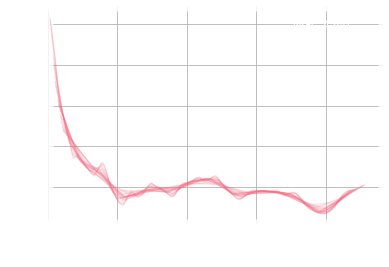

In [15]:
# with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer_blackTicks.mplstyle"):
with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer.mplstyle"):
    fig, ax = plt.subplots()
    for rp_result in rp_results:
        ebar = ax.errorbar(
            x=rp_result.radii * px_to_kpc,
            y=rp_result.avg_data,
        #     yerr=galaxy_rp.avg_data_err,  # uncertainty in the mean/median from bootstrapping
            fmt="-",
            color=sns.color_palette("husl", 8)[0],
            alpha=0.1,
            lw=1,
        #     ecolor="r",
        #     elinewidth=1,
        #     capsize=2,
        )
    # ebar2[-1][0].set_linestyle("--")
    # 
    # Add name of galaxy
    # 
    high_i_str = "*" if gal_rp.i >= I_THRESHOLD else ""
    ax.text(
        0.9,
        0.9,
        re.sub(r"(\d+)", " \\1", gal_to_plot) + high_i_str,
        c="w",
        ha="right",
        transform=ax.transAxes,
    )
    # 
    # Other parameters
    # 
    ax.set_xlim(left=0)
    ax.set_xlabel("Radius [kpc]")
    ax.set_ylabel(
        rp_results[0].rp_options["func"].capitalize() + " u-g Colour"
    )
    # fig.savefig(gal_to_plot_path + f"{gal_to_plot}_vorbin_SNR50_{quantity_to_plot}_{num_radial_profiles}radProfs_extinctionCorr_34annuli_beamer.pdf")
    plt.show()